# PREPROCESAMIENTO

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import warnings
import datetime
import psycopg2
import pandas.io.sql as psql
from time import time
warnings.filterwarnings("ignore")
%matplotlib inline

## CARGA DESDE SQL POSTGRES

In [2]:
# connection = psycopg2.connect(user = "postgres", password = "guille12", host = "127.0.0.1", port = "5432",
#                               database = "TFM_Soccer")
# df_original = psql.read_sql("select*from full_matches", connection)

In [3]:
# def create_table(name, conection): 
#     """Está función crea dataframes desde la base de datos sql con una sencilla consulta select*from"""
#     return psql.read_sql("select*from " + name ,conection)

## CARGA DESDE SQLITE

In [4]:
#ruta = 'C:/Users/garrabal/Desktop/Personal/TFM/soccer/'
ruta = 'E:/MASTER BIGDATA/BigData/TFM/'
#ruta = '/media/guille/Maxtor_Guille/MASTER BIGDATA/BigData/TFM/'
dbase = ruta + 'database.sqlite'
conexion = sqlite3.connect(dbase)

In [5]:
def create_table(name, conection): 
    """Está función crea dataframes desde la base de datos sql con una sencilla consulta select*from"""
    return pd.read_sql("SELECT*FROM " + name ,conection)


In [6]:
tablas = create_table("sqlite_master WHERE type='table'", conexion)
tablas
del tablas,

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...
8,table,corner_detail,corner_detail,305672,"CREATE TABLE corner_detail(\ncoordinates text,..."
9,table,possesion,possesion,310713,"CREATE TABLE possesion(\nawaypos integer,\ncar..."


In [7]:
# 1 Vamos importar el fichero partidos
match = create_table("Match",conexion)
print("Dimensiones Match:",match.shape)
# 2 Importamos el fichero de ligas
leagues =create_table("League",conexion).rename(columns={"name":"League"})
print("Dimensiones Leages:" ,leagues.shape)
# 3 Importamos el fichero de paises
countries = create_table("Country",conexion).rename(columns={"name":"Country"})
print("Dimensiones Countries:", countries.shape)
# 4 Importamos el fichero de equipos
teams = create_table("Team",conexion)
teams = teams[['team_api_id', 'team_long_name']]
print("Dimensiones teams:", teams.shape)
# 5 Importamos el fichero de atruputos de jugadores
players = create_table("Player_Attributes",conexion)
print("Dimensiones players:", players.shape)
del match,

Dimensiones Match: (25979, 115)
Dimensiones Leages: (11, 3)
Dimensiones Countries: (11, 2)
Dimensiones teams: (299, 2)
Dimensiones players: (183978, 42)


In [8]:
# 6 Importamos la tabla de partidos que será la mas importante
full_matches = create_table("full_matches",conexion).drop(columns = ['match_id2','march_id3','minuto'])
matches = full_matches[full_matches['match_id'].notnull()]
matches.shape
print("Dimensiones FullMatches:", full_matches.shape)

(8464, 121)

Dimensiones FullMatches: (25979, 121)


#### Código adicional en el caso de tener los ficheros en csv

In [9]:
# 1 Vamos importar el fichero partidos
#fichero = 'match.csv'
#ruta = 'C:/Users/garrabal/Desktop/Personal/TFM/soccer/'
#ruta = '/media/guille/Maxtor_Guille/MASTER BIGDATA/BigData/TFM/'
#matches = pd.read_csv(ruta + fichero, sep = "|")

# 2 Importamos el fichero de ligas
#fichero = 'league.csv'
#leagues = pd.read_csv(ruta + fichero, sep = "|").rename(columns={"name":"League"})

# 3 Importamos el fichero de paises
#fichero = 'country.csv'
#countries = pd.read_csv(ruta + fichero, sep = "|").rename(columns={"name":"Country"})

# 4 Importamos el fichero de equipos
#fichero = 'team.csv'
#teams = pd.read_csv(ruta + fichero, sep = "|")#.rename(columns={"name":"Country"})
#teams = teams[['team_api_id', 'team_long_name']]

## Feature Engineering

### Variable target y goal difference

In [10]:
def create_stats(matches):
    '''Vamos a crear el campo diferencia de goles y status del partido, victoria o derrota'''
    #Creamos campo diferencia de goles
    matches['Goal_Difference'] = matches.home_team_goal - matches.away_team_goal
    matches['home_status'] = np.where(matches['Goal_Difference'] > 0, 'W', 
                             np.where(matches['Goal_Difference'] < 0, 'L', 'D'))
    matches['target'] = np.where(matches['home_status'] == 'W', 1, 
                             np.where(matches['home_status'] == 'L', -1, 0))
    matches['homepos'] = matches['homepos'].fillna('50')
    matches['awaypos'] = matches['awaypos'].fillna('50')
    print(matches.shape)
    home_players = ["home_player_" + str(x) for x in range(1, 12)]
    away_players = ["away_player_" + str(x) for x in range(1, 12)]
    return matches , home_players, away_players

In [11]:
matches , home_players, away_players = create_stats(matches)

(8464, 124)


#### Datos de Partidos

In [12]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    player_stats_new = pd.DataFrame()
    names = []
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5","home_player_6", 
               "home_player_7", "home_player_8", "home_player_9", "home_player_10","home_player_11", "away_player_1", 
               "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6", "away_player_7",
               "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
    
    for player in players:    
        #Sacamos id y estadisticas
        player_id = match[player]
        #Sacamos estadísticas mas actuales posibles 
        stats = player_stats[player_stats.player_api_id == player_id]     
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])
        #Asignamos el nombre
        name = "overall_rating_{}".format(player)
        names.append(name)  
        #Agregamos al dataframe que estamos creando
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id
    
    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Devolvemos estadísticas del jugador     
    return player_stats_new.ix[0]  

In [13]:
def create_fifa_data(matches, players, path = None ):
    ''' Iteramos por todos los partidos para sacar las estadísticas con la función anterior '''  
    #Como la función tarda mucho podemos almacenar la información
    data_existe = False
    if data_existe == True:       
        fifa_data = pd.read_pickle(path) 
    else:  
        start = time()
        #Apicamos la función anterior a todos y cada uno de los partidos get_fifa_stats for each match
        datos_fifa = matches.apply(lambda x :get_fifa_stats(x, players), axis = 1)
        end = time()    
        print("Datos recogidos en{:.1f} minutos".format((end - start)/60))
    datos_fifa.replace(0, np.nan, inplace=True)
    return datos_fifa

In [14]:
players.id = players.index
datos_fifa = create_fifa_data(matches, players)

Datos recogidos en10.4 minutos


In [15]:
datos_fifa.match_api_id = datos_fifa.match_api_id.astype(int)
datos_fifa
#fifa_data.replace(0, np.nan, inplace=True)

,overall_rating_home_player_1,overall_rating_home_player_2,overall_rating_home_player_3,overall_rating_home_player_4,overall_rating_home_player_5,overall_rating_home_player_6,overall_rating_home_player_7,overall_rating_home_player_8,overall_rating_home_player_9,overall_rating_home_player_10,...,overall_rating_away_player_3,overall_rating_away_player_4,overall_rating_away_player_5,overall_rating_away_player_6,overall_rating_away_player_7,overall_rating_away_player_8,overall_rating_away_player_9,overall_rating_away_player_10,overall_rating_away_player_11,match_api_id
1728,85.0,79.0,88.0,85.0,78.0,74.0,83.0,85.0,86.0,74.0,...,77.0,78.0,76.0,77.0,56.0,69.0,75.0,76.0,83.0,489042
1729,75.0,76.0,85.0,74.0,77.0,72.0,79.0,75.0,85.0,87.0,...,63.0,79.0,69.0,71.0,71.0,73.0,72.0,74.0,68.0,489043
1730,78.0,80.0,71.0,61.0,66.0,79.0,78.0,75.0,74.0,81.0,...,88.0,79.0,60.0,84.0,89.0,70.0,80.0,84.0,87.0,489044
1731,77.0,79.0,79.0,75.0,77.0,77.0,72.0,82.0,76.0,73.0,...,69.0,69.0,74.0,76.0,71.0,67.0,79.0,71.0,77.0,489045
1732,82.0,74.0,76.0,75.0,77.0,81.0,78.0,82.0,77.0,76.0,...,83.0,79.0,73.0,58.0,81.0,65.0,NaN,80.0,58.0,489046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,81.0,81.0,79.0,85.0,82.0,80.0,81.0,83.0,78.0,84.0,...,82.0,80.0,80.0,82.0,79.0,77.0,80.0,79.0,75.0,2030167
24553,79.0,75.0,74.0,78.0,76.0,75.0,76.0,74.0,73.0,72.0,...,75.0,77.0,75.0,75.0,77.0,76.0,74.0,73.0,78.0,2030168
24554,79.0,80.0,77.0,83.0,79.0,80.0,81.0,80.0,74.0,78.0,...,74.0,76.0,73.0,71.0,75.0,73.0,76.0,77.0,72.0,2030169
24555,77.0,71.0,74.0,72.0,73.0,76.0,75.0,74.0,70.0,75.0,...,72.0,76.0,71.0,79.0,75.0,71.0,75.0,72.0,79.0,2030170


#### Datos de jugadores

In [16]:
#Nola utilizamos, cambiamos por la de fifa stats
def create_fifa_stats(matches, home_players, away_players):
    #Traemos caracteristicas jugadores locales
    for jugador in home_players:
        matches = pd.merge(matches, players[["index", "overall_rating"]],how = 'left', left_on=[
            jugador], right_on=["index"] , suffixes=["", "_" + jugador])
    #Traemos características jugadores visitantes
    for jugador in away_players:
        matches = pd.merge(matches, players[["index", "overall_rating"]],how = 'left', left_on=[
            jugador], right_on=["index"] , suffixes=["", "_" + jugador]) 
    #Rename
    matches = matches.rename(columns={"overall_rating": "overall_rating_home_player_1"})
    print("Creadas estadísticas Fifa",matches.shape)
    return matches


In [17]:
#Fill na
def fill_na_fifa_stats(matches, home_players, away_players):
    columns =  ['league_id', 'season','home_team_api_id']
    columns2 =  ['league_id', 'season']
    for jugador in home_players:
        matches['overall_rating_' + jugador] = matches.groupby(columns)['overall_rating_' + jugador
                                                                       ].apply(lambda x: x.fillna(x.mean()))
        matches['overall_rating_' + jugador] = matches.groupby(columns2)['overall_rating_' + jugador
                                                                       ].apply(lambda x: x.fillna(x.mean()))
        matches['overall_rating_' + jugador] = matches['overall_rating_' + jugador].fillna(50)
    for jugador in away_players:
        matches['overall_rating_' + jugador] = matches.groupby(columns)['overall_rating_' + jugador
                                                                       ].apply(lambda x: x.fillna(x.mean()))
        matches['overall_rating_' + jugador] = matches.groupby(columns2)['overall_rating_' + jugador
                                                                       ].apply(lambda x: x.fillna(x.mean()))
        matches['overall_rating_' + jugador] = matches['overall_rating_' + jugador].fillna(50)
    print("Actualizadas Estadísticas Jugadores con NA")
    return matches

In [18]:
def create_fifa_overall_stats(matches, home_players, away_players):
    #Diferencias rating home y away
    matches['overall_rating_home'] = matches[['overall_rating_' + p for p in home_players]].sum(axis=1)
    matches['overall_rating_away'] = matches[['overall_rating_' + p for p in away_players]].sum(axis=1)
    matches['overall_rating_difference'] = matches['overall_rating_home'] - matches['overall_rating_away']
    #Characteristics
    matches['min_overall_rating_home'] = matches[['overall_rating_' + p for p in home_players]].min(axis=1)
    matches['min_overall_rating_away'] = matches[['overall_rating_' + p for p in away_players]].min(axis=1)

    matches['max_overall_rating_home'] = matches[['overall_rating_' + p for p in home_players]].max(axis=1)
    matches['max_overall_rating_away'] = matches[['overall_rating_' + p for p in away_players]].max(axis=1)

    matches['mean_overall_rating_home'] = matches[['overall_rating_' + p for p in home_players]].mean(axis=1)
    matches['mean_overall_rating_away'] = matches[['overall_rating_' + p for p in away_players]].mean(axis=1)

    matches['std_overall_rating_home'] = matches[['overall_rating_' + p for p in home_players]].std(axis=1)
    matches['std_overall_rating_away'] = matches[['overall_rating_' + p for p in away_players]].std(axis=1)

    matches = matches[matches['overall_rating_home'] >= 1]
    matches = matches[matches['overall_rating_away'] >= 1]
    print("Overall fifa stats created")
    return matches


In [19]:
matches = pd.merge(matches, datos_fifa, how = 'left', left_on=['match_api_id'], right_on=['match_api_id'] ,
                   suffixes=["", "_"])
matches = fill_na_fifa_stats(matches, home_players, away_players)
matches = create_fifa_overall_stats(matches, home_players, away_players)

Actualizadas Estadísticas Jugadores con NA
Overall fifa stats created


In [20]:
def ultimos_partidos(matches, dates, equipo, z = 8):
    '''queremos analizar ultimos z partidos de un equipo'''
    team_match = matches[(matches['home_team_api_id'] == equipo) | (matches['away_team_api_id'] == equipo)]
    last_match = team_match[team_match.date < dates].sort_values(by = 'date', ascending = False).iloc[0:z,:]
    return last_match

def goles_anotados_y_recibidos(matches, equipo):
    ''' cuantos goles han marcado en casa y fuera'''
    goles_recibidos_casa = int(matches.home_team_goal[matches.away_team_api_id == equipo].sum())
    goles_recibidos_fuera = int(matches.away_team_goal[matches.home_team_api_id == equipo].sum())
    
    goles_casa = int(matches.home_team_goal[matches.home_team_api_id == equipo].sum())
    goles_fuera = int(matches.away_team_goal[matches.away_team_api_id == equipo].sum())
    
    total = goles_fuera + goles_casa
    total_recibidos = goles_recibidos_fuera + goles_recibidos_casa
    
    return total, total_recibidos

def consecutive_wins(matches, equipo):
    '''sacaremos victorias'''
    home_win = int(matches.home_team_goal[(matches.home_team_api_id == equipo) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_win = int(matches.away_team_goal[(matches.away_team_api_id == equipo) & (matches.away_team_goal > matches.home_team_goal)].count())
   
    wins = away_win + home_win    
    return wins

def consecutive_draws(matches, equipo):
    '''sacaremos empates'''
    home_draw = int(matches.home_team_goal[(matches.home_team_api_id == equipo) & (matches.home_team_goal == matches.away_team_goal)].count())
    away_draw = int(matches.away_team_goal[(matches.away_team_api_id == equipo) & (matches.away_team_goal == matches.home_team_goal)].count())
   
    draws = home_draw + away_draw    
    return draws

def last_games_against(df, dates, home_team, away_team, z = 6):
    '''ultimos enfrentamientos entre equipos'''
    home_match = df[(df['home_team_api_id'] == home_team) & (df['away_team_api_id'] == away_team)] 
    away_match = df[(df['home_team_api_id'] == away_team) & (df['away_team_api_id'] == home_team)]
    total_match = pd.concat([away_match , home_match])
    try:
        last_matches = total_match[total_match.date < dates].sort_values(by = 'date', ascending = False).iloc[0:z,:]
    except:
        last_matches = total_match[total_match.date < dates].sort_values(by = 'date', ascending = False
                                                                        ).iloc[0:total_match.shape[0],:]
        if(last_matches.shape[0] > x): print("Mistake obtaining matches")
    return last_matches

def possesion_statistics(matches, equipo):
    '''posesion como local y visitante'''
    home_possesion = int(matches.homepos[matches.home_team_api_id == equipo].sum())
    away_possesion = int(matches.awaypos[matches.away_team_api_id == equipo].sum())
    
    total_possesion = home_possesion + away_possesion
    return total_possesion

def create_team_stats(partido, matches, z = 8):
    '''creamos las estadísticas para cada partido'''
    
    home_team = partido['home_team_api_id']
    away_team = partido['away_team_api_id']
    dates = partido['date']
    #Ultimos partidos en casa y fuera
    home_team_matches = ultimos_partidos(matches, dates, home_team, z = 10)
    away_team_matches = ultimos_partidos(matches, dates, away_team, z = 10)
    #Ultimos partidos entre los dos equipos:
    matches_against = last_games_against(matches, dates, home_team, away_team, z = 4)
    #Goles recibidos en casa y fuera
    home_goals, home_goals_recieved = goles_anotados_y_recibidos(home_team_matches, home_team)
    away_goals, away_goals_recieved = goles_anotados_y_recibidos(away_team_matches, away_team)
    #Posesiones en casa y fuera
    home_possesion = possesion_statistics(home_team_matches, home_team)
    away_possesion = possesion_statistics(away_team_matches, away_team)
    
    #Vamos a crear nuevo df
    stats = pd.DataFrame()
    stats.loc[0, 'match_api_id'] = int(partido['match_api_id'])
    stats.loc[0, 'league_id'] = int(partido['league_id'])
    stats.loc[0, 'home_team_goals_scored_lastmatches'] = home_goals
    stats.loc[0, 'away_team_goals_scored_lastmatches'] = away_goals
    stats.loc[0, 'home_team_goals_recieved_lastmatches'] = home_goals_recieved
    stats.loc[0, 'away_team_goals_recieved_lastmatches'] = away_goals_recieved
    stats.loc[0, 'home_possesion'] = home_possesion
    stats.loc[0, 'away_possesion'] = away_possesion
    stats.loc[0, 'home_team_dif_goals'] = home_goals - home_goals_recieved
    stats.loc[0, 'away_team_dif_goals'] = away_goals - away_goals_recieved
    stats.loc[0, 'games_won_h_team'] = consecutive_wins(home_team_matches, home_team) 
    stats.loc[0, 'games_won_a_team'] = consecutive_wins(away_team_matches, away_team)
    stats.loc[0, 'games_against_won'] = consecutive_wins(matches_against, home_team)
    stats.loc[0, 'games_against_lost'] = consecutive_wins(matches_against, away_team)   
    stats.loc[0, 'games_against_draw'] = consecutive_draws(matches_against, away_team)
    stats.loc[0, 'games_draw_h_team'] = consecutive_draws(home_team_matches, home_team) 
    stats.loc[0, 'games_draw_a_team'] = consecutive_draws(away_team_matches, away_team)
    

    return stats.loc[0]

In [21]:
matches['homepos'] = pd.to_numeric(matches['homepos'],errors='coerce')
matches['awaypos'] = pd.to_numeric(matches['awaypos'],errors='coerce')

In [22]:
home_goals = matches['home_team_goal']
away_goals = matches['away_team_goal']
start = time()
match_stats = matches.apply(lambda y: create_team_stats(y, matches, z = 10), axis = 1)
end = time()    
print("Datos recogidos en{:.1f} minutos".format((end - start)/60))
match_stats['match_api_id'] = match_stats['match_api_id'].map(int)
match_stats['league_id'] = match_stats['league_id'].map(int)
match_stats

Datos recogidos en6.6 minutos


,match_api_id,league_id,home_team_goals_scored_lastmatches,away_team_goals_scored_lastmatches,home_team_goals_recieved_lastmatches,away_team_goals_recieved_lastmatches,home_possesion,away_possesion,home_team_dif_goals,away_team_dif_goals,games_won_h_team,games_won_a_team,games_against_won,games_against_lost,games_against_draw,games_draw_h_team,games_draw_a_team
0,489042,1729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,489043,1729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,489044,1729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,489045,1729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,489046,1729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,2030167,21518,12.0,11.0,5.0,8.0,467.0,521.0,7.0,3.0,5.0,4.0,0.0,2.0,2.0,2.0,4.0
8460,2030168,21518,6.0,18.0,12.0,11.0,476.0,467.0,-6.0,7.0,1.0,4.0,1.0,0.0,2.0,3.0,5.0
8461,2030169,21518,17.0,15.0,14.0,12.0,480.0,458.0,3.0,3.0,4.0,4.0,0.0,1.0,3.0,2.0,3.0
8462,2030170,21518,11.0,12.0,16.0,16.0,463.0,454.0,-5.0,-4.0,2.0,3.0,1.0,1.0,0.0,3.0,4.0


In [23]:
columns = ['match_api_id', 'league_id']
matches = pd.merge(matches, match_stats, left_on = columns, right_on = columns, how = 'left')
matches['homepos'] = pd.to_numeric(matches['homepos'],errors='coerce')
matches['awaypos'] = pd.to_numeric(matches['awaypos'],errors='coerce')

### Preprocesado y Auditoría 

In [24]:
for c in matches.columns:
    if '_player_' in c:
        if not 'overall_rating' in c:
            matches = matches.drop(c, axis=1)

#### Merge con las tablas de países equipos y ligas

In [25]:
#Aqui hacemos un merge con countries and leagues.
country_league = countries.merge(leagues, left_on = 'id', right_on= 'country_id', 
                                 how = 'inner').drop(columns=['id_x', 'id_y'])
country_league
matches = matches.merge(country_league, on= 'country_id', how = 'left').drop(columns=['country_id', 'league_id'])

#Aqui hacemos un merge con los nombres de equipos
matches = matches.merge(teams, right_on='team_api_id',left_on='home_team_api_id').rename(columns={
    "team_long_name":"Home_team_name"}).drop(columns=['home_team_api_id'])
matches = matches.merge(teams, right_on='team_api_id',left_on='away_team_api_id').rename(columns={
    "team_long_name":"Away_team_name"}).drop(columns=['away_team_api_id', 'team_api_id_y','team_api_id_x'])


,Country,country_id,League
0,Belgium,1,Belgium Jupiler League
1,England,1729,England Premier League
2,France,4769,France Ligue 1
3,Germany,7809,Germany 1. Bundesliga
4,Italy,10257,Italy Serie A
5,Netherlands,13274,Netherlands Eredivisie
6,Poland,15722,Poland Ekstraklasa
7,Portugal,17642,Portugal Liga ZON Sagres
8,Scotland,19694,Scotland Premier League
9,Spain,21518,Spain LIGA BBVA


In [26]:
matches = matches.drop(columns = {'possession', 'shoton', 'shotoff', 'corner', 'foulcommit', 'cross', 'goal','card'})

In [27]:
#Ahora vamos a visualizar todas las columnas que tenemos en el dataset.
pd.set_option('display.max_rows', 500) # para que al visualizar imprima todas las celdas
matches.dtypes

id                                        int64
season                                   object
stage                                     int64
date                                     object
match_api_id                              int64
home_team_goal                            int64
away_team_goal                            int64
B365H                                   float64
B365D                                   float64
B365A                                   float64
BWH                                     float64
BWD                                     float64
BWA                                     float64
IWH                                     float64
IWD                                     float64
IWA                                     float64
LBH                                     float64
LBD                                     float64
LBA                                     float64
PSH                                     float64
PSD                                     

In [28]:
matches.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,8464.0,1.038042e+04,7295.272217,1729.000000,3845.750000,8.839500e+03,1.313425e+04,2.455700e+04
stage,8464.0,1.914355e+01,10.724795,1.000000,10.000000,1.900000e+01,2.800000e+01,3.800000e+01
match_api_id,8464.0,1.354481e+06,548980.670855,489042.000000,856911.750000,1.474372e+06,1.983287e+06,2.118418e+06
home_team_goal,8464.0,1.567344e+00,1.325703,0.000000,1.000000,1.000000e+00,2.000000e+00,1.000000e+01
away_team_goal,8464.0,1.165288e+00,1.155302,0.000000,0.000000,1.000000e+00,2.000000e+00,9.000000e+00
B365H,8453.0,2.719306e+00,1.997052,1.040000,1.620000,2.100000e+00,2.900000e+00,2.600000e+01
B365D,8453.0,3.967878e+00,1.287804,1.400000,3.300000,3.500000e+00,4.000000e+00,1.700000e+01
B365A,8453.0,4.914844e+00,4.225135,1.080000,2.500000,3.500000e+00,5.500000e+00,4.100000e+01
BWH,8447.0,2.642492e+00,1.803856,1.030000,1.650000,2.150000e+00,2.850000e+00,3.400000e+01
BWD,8447.0,3.858571e+00,1.182583,1.650000,3.250000,3.400000e+00,4.000000e+00,1.950000e+01


In [29]:
def print_datatype(datatype, df):
    """ Parámetro data type ('object', 'int64', 'float64')
        Parámetro df: nombre del dataframe
        Devuelve Dataframe con nombre de columna, valores distintos, cantidad de valores distinos y número de NA."""
    list = df.dtypes[df.dtypes == datatype].index.tolist()
    x, y, z = [], [], []
    for i in list:
        a = df[i].unique()
        x.append(a)
        y.append(len(a))
        z.append(df[i].isnull().sum())
    tempdf = pd.DataFrame({'Unique Values': x, 'qty': y, 'na': z}, index=[list])
    print("\nData Frame 'Matches' contains following columns of", datatype, "data")
    return tempdf.sort_values('qty')

#### Vamos a visualizar la "shape" de nuestro dataframe (número de filas y columnas), y todos los valores por columna agrupados por tipo de dato.

In [30]:
#Ahora vamos a visualizar por tipo de dato cada una de nuestras columnas
print("Shape of the dataframe:", matches.shape)
print_datatype('int64',matches )

Shape of the dataframe: (8464, 98)

Data Frame 'Matches' contains following columns of int64 data


,Unique Values,qty,na
away_team_goal,"[1, 0, 3, 2, 4, 5, 6, 9, 7, 8]",10,0
home_team_goal,"[1, 3, 4, 0, 2, 7, 5, 6, 8, 9, 10]",11,0
Goal_Difference,"[0, 3, 1, -1, 2, 4, -2, -3, 5, -4, 7, 8, -5, 6...",18,0
stage,"[1, 13, 19, 15, 18, 3, 11, 28, 20, 36, 16, 9, ...",38,0
id,"[1729, 2494, 2913, 3353, 3693, 4105, 4613, 195...",8464,0
match_api_id,"[489042, 839802, 1024845, 1229300, 1474518, 17...",8464,0


In [31]:
print_datatype('float64',matches )


Data Frame 'Matches' contains following columns of float64 data


,Unique Values,qty,na
games_against_draw,"[0.0, 1.0, 2.0, 3.0, 4.0]",5,0
games_against_lost,"[0.0, 1.0, 2.0, 3.0, 4.0]",5,0
games_against_won,"[0.0, 1.0, 2.0, 3.0, 4.0]",5,0
games_draw_a_team,"[0.0, 3.0, 1.0, 2.0, 5.0, 6.0, 4.0, 7.0, 8.0]",9,0
games_draw_h_team,"[0.0, 1.0, 2.0, 3.0, 6.0, 4.0, 5.0, 7.0, 8.0]",9,0
games_won_a_team,"[0.0, 1.0, 6.0, 3.0, 5.0, 4.0, 2.0, 7.0, 8.0, ...",11,0
games_won_h_team,"[0.0, 8.0, 7.0, 4.0, 6.0, 5.0, 1.0, 2.0, 3.0, ...",11,0
corners,"[12.0, 8.0, 14.0, 4.0, 9.0, 16.0, 10.0, 15.0, ...",25,0
shotsoff,"[19.0, 12.0, 16.0, 13.0, 8.0, 7.0, 10.0, 15.0,...",27,3
shotson,"[12.0, 11.0, 20.0, 13.0, 8.0, 6.0, 19.0, 9.0, ...",29,2


In [32]:
print_datatype('object',matches )


Data Frame 'Matches' contains following columns of object data


,Unique Values,qty,na
home_status,"[D, W, L]",3,0
season,"[2008/2009, 2010/2011, 2011/2012, 2012/2013, 2...",8,0
Country,"[England, France, Germany, Italy, Netherlands,...",8,0
League,"[England Premier League, France Ligue 1, Germa...",8,0
Home_team_name,"[Manchester United, Arsenal, Sunderland, West ...",174,0
Away_team_name,"[Newcastle United, West Ham United, Hull City,...",175,0
date,"[2008-08-17 00:00:00, 2010-08-16 00:00:00, 201...",1181,0


#### Vamos a trabajar los valores na restantes:

In [33]:
# Vamos a ir modelando las columnas
matches['season'] = matches['season'].astype(str)
matches['date'] = pd.to_datetime(matches['date'], format = '%Y/%m/%d')

In [34]:
columns2 =  ['League', 'season']
for c in matches.columns:
    if 'pos' in c and matches[c].isna().sum() >0:
        print(c)
        matches[c] = matches.groupby(columns2)[c].apply(lambda x: x.fillna(x.mean()))
    if 'shotson' in c and matches[c].isna().sum() >0:
        print(c)
        matches[c] = matches.groupby(columns2)[c].apply(lambda x: x.fillna(x.mean()))
    if 'shotsoff' in c and matches[c].isna().sum() >0:
        print(c)
        matches[c] = matches.groupby(columns2)[c].apply(lambda x: x.fillna(x.mean()))
    if matches[c].isna().sum() >0:
        matches[c] = matches[c].fillna('')


awaypos
homepos
shotson
shotsoff


In [35]:
print("\nNumero de missing values por columna :\n\n", matches.isna().sum())


Numero de missing values por columna :

 id                                      0
season                                  0
stage                                   0
date                                    0
match_api_id                            0
home_team_goal                          0
away_team_goal                          0
B365H                                   0
B365D                                   0
B365A                                   0
BWH                                     0
BWD                                     0
BWA                                     0
IWH                                     0
IWD                                     0
IWA                                     0
LBH                                     0
LBD                                     0
LBA                                     0
PSH                                     0
PSD                                     0
PSA                                     0
WHH                               

### Tratamos de reducir la dimensionalidad y estandarizamos

In [36]:
columns = ['overall_rating_home_player_1', 'overall_rating_home_player_2','overall_rating_home_player_3',
           'overall_rating_home_player_4', 'overall_rating_home_player_5', 'overall_rating_home_player_6',
       'overall_rating_home_player_7', 'overall_rating_home_player_8', 'overall_rating_home_player_9', 
       'overall_rating_home_player_10', 'overall_rating_home_player_11', 'overall_rating_away_player_1',
       'overall_rating_away_player_2', 'overall_rating_away_player_3', 'overall_rating_away_player_4', 
       'overall_rating_away_player_5', 'overall_rating_away_player_6', 'overall_rating_away_player_7',
       'overall_rating_away_player_8', 'overall_rating_away_player_9', 'overall_rating_away_player_10', 
       'overall_rating_away_player_11', 'match_api_id']
matches['overall_rating_home_player_11'] = matches['overall_rating_home_player_11'].fillna(50)
matches['overall_rating_home_player_11'] = pd.to_numeric(matches['overall_rating_home_player_11'],errors='coerce')

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
target = ['match_api_id']
x = matches[columns].drop(columns = target)
y = matches[target].values
X_std = StandardScaler().fit_transform(x)
X_std.shape

(8464, 22)

In [38]:
# Calculamos la matriz de covarianza

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

#Calculamos los autovalores y autovectores de la matriz y los mostramos

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

NumPy covariance matrix: 
[[1.00011816 0.48573135 0.518621   0.52656178 0.48445708 0.52141778
  0.51437928 0.502865   0.49050773 0.5148834  0.50983998 0.06385709
  0.0448035  0.04577151 0.04857825 0.05334452 0.05574818 0.04431441
  0.05431524 0.05737233 0.05737381 0.07703129]
 [0.48573135 1.00011816 0.51026202 0.48756739 0.47416961 0.53501019
  0.52958423 0.51075862 0.50552871 0.5306917  0.52199133 0.06161651
  0.04177425 0.04582083 0.04861406 0.06606839 0.05632835 0.04837861
  0.06212202 0.04331021 0.05642227 0.07470086]
 [0.518621   0.51026202 1.00011816 0.53467689 0.53872112 0.56650639
  0.56342383 0.55507556 0.5616948  0.5772704  0.56822516 0.03059761
  0.02165469 0.03565559 0.03698867 0.03766609 0.0380297  0.01153557
  0.03432047 0.02710889 0.03747725 0.05480906]
 [0.52656178 0.48756739 0.53467689 1.00011816 0.52705159 0.56383647
  0.53520506 0.54013323 0.53097286 0.55330243 0.5469283  0.05365292
  0.0463374  0.03833044 0.04383824 0.04664152 0.04844443 0.04278108
  0.04878036 0.04

In [39]:
#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
6.9966036897573645
5.778136602472822
0.5679770082638215
0.5513303946647686
0.5408303956708798
0.5297913820047916
0.4877195494672965
0.4747893968932018
0.47336403902472735
0.46686046924681174
0.46568617413406066
0.4582493916136499
0.45411155825011806
0.4415793202746714
0.4379512316289693
0.4285118028343791
0.42389192540301784
0.42225254340448765
0.4131019948818941
0.4068294386862473
0.3941910944516092
0.38884014795705985


<Figure size 432x288 with 0 Axes>

<BarContainer object of 22 artists>

Text(0, 0.5, 'Ratio de Varianza Explicada')

Text(0.5, 0, 'Componentes Principales')

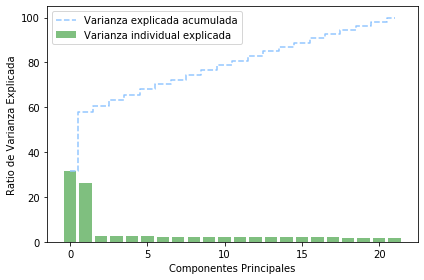

In [40]:
# A partir de los autovalores, calculamos la varianza explicadaº
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(22), var_exp, alpha=0.5, align='center',label='Varianza individual explicada', color='g')
    plt.step(range(22), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout();

In [41]:
# Esta teoría no vamos a utilizarla ya que no hay ninguna variable predominante 

In [42]:
matches.columns

Index(['id', 'season', 'stage', 'date', 'match_api_id', 'home_team_goal',
       'away_team_goal', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
       'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA',
       'BSH', 'BSD', 'BSA', 'match_id', 'corners', 'awaypos', 'homepos',
       'shotson', 'shotsoff', 'Goal_Difference', 'home_status', 'target',
       'overall_rating_home_player_1', 'overall_rating_home_player_2',
       'overall_rating_home_player_3', 'overall_rating_home_player_4',
       'overall_rating_home_player_5', 'overall_rating_home_player_6',
       'overall_rating_home_player_7', 'overall_rating_home_player_8',
       'overall_rating_home_player_9', 'overall_rating_home_player_10',
       'overall_rating_home_player_11', 'overall_rating_away_player_1',
       'overall_rating_away_player_2', 'overall_rating_away_player_3',
       'overall_rating_away_player_4', 'overal

In [43]:
match_labels = ['date','season','match_api_id','stage','overall_rating_home', 'overall_rating_away','overall_rating_difference', 
    'min_overall_rating_home', 'min_overall_rating_away', 'max_overall_rating_home','max_overall_rating_away', 
    'mean_overall_rating_home', 'mean_overall_rating_away', 'std_overall_rating_home','std_overall_rating_away', 
    'home_team_goals_scored_lastmatches', 'away_team_goals_scored_lastmatches', 'home_team_dif_goals', 'away_team_dif_goals',
    'games_won_h_team', 'games_won_a_team','games_against_won', 'games_against_lost','games_draw_h_team','games_draw_a_team',
    'games_against_draw', 'home_team_goals_recieved_lastmatches', 'away_team_goals_recieved_lastmatches','home_possesion',
    'away_possesion','target'] 
betting_info = ['match_api_id','B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH','IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 
    'PSD', 'PSA', 'WHH', 'WHD','WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA','BSH', 'BSD', 'BSA',]


In [44]:
pplot = matches[match_labels]

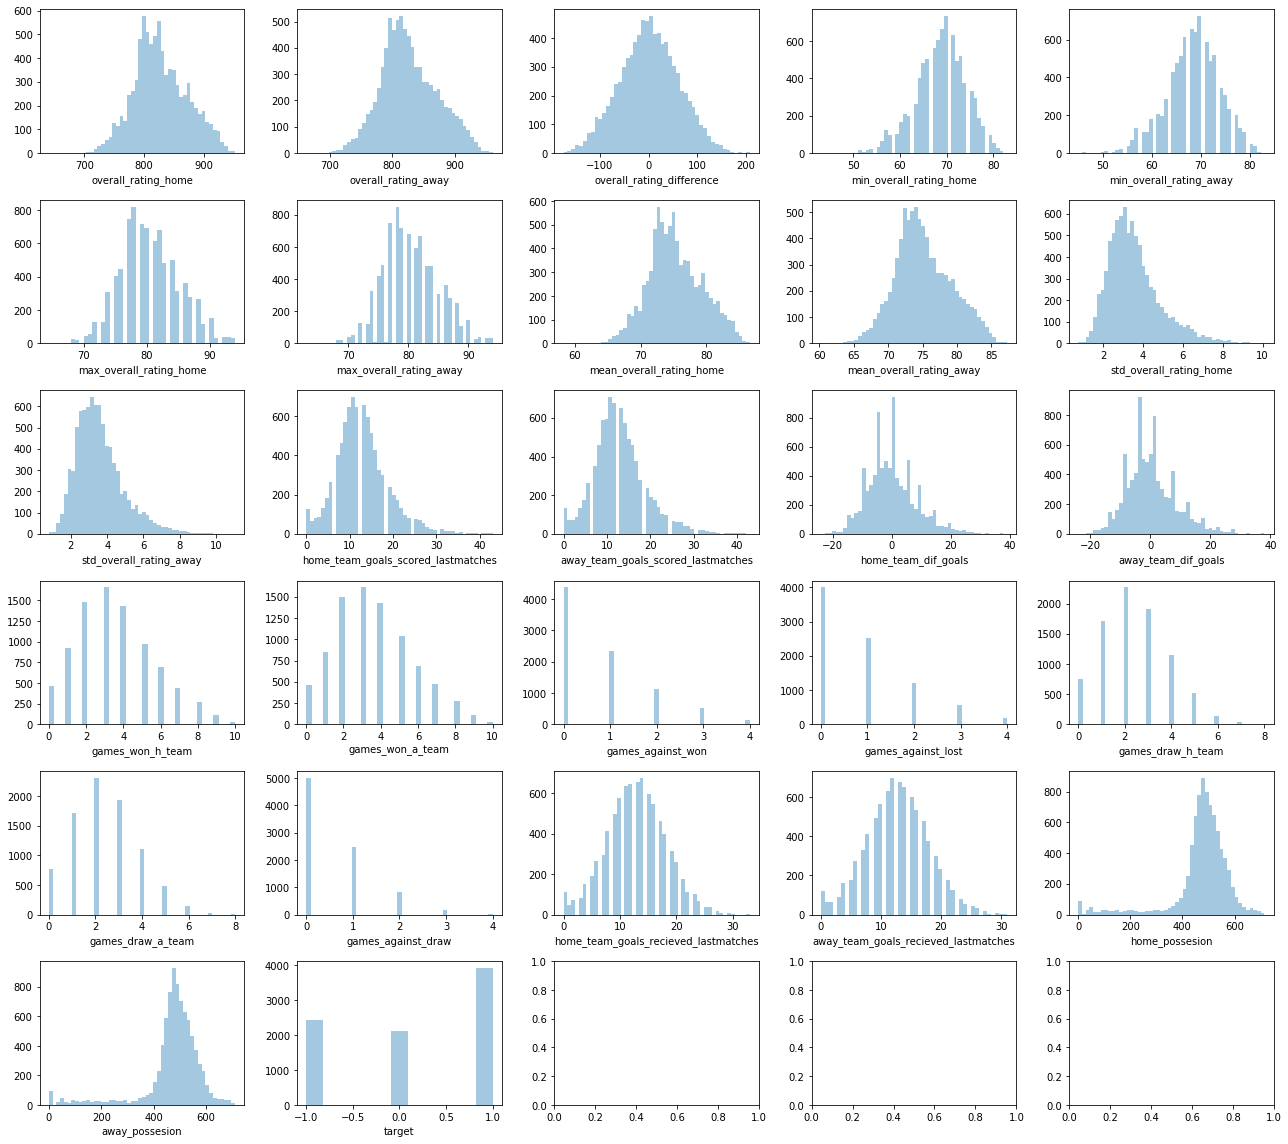

In [45]:
#sns.kdeplot(players.overall_rating, shade=True, color="b")
fig1, ax1 = plt.subplots(nrows=6,ncols=5)
fig1.set_size_inches(18,16)
for i,j in enumerate(pplot.select_dtypes(include = ['float64','int64','int32']).columns[2:].tolist()):
    sns.distplot(pplot.loc[:,j],kde = False,hist = True, ax = ax1[int(i/5)][i%5])
fig1.tight_layout();

### Visualizamos los resultados datos preparados

(29.0, 0.0)

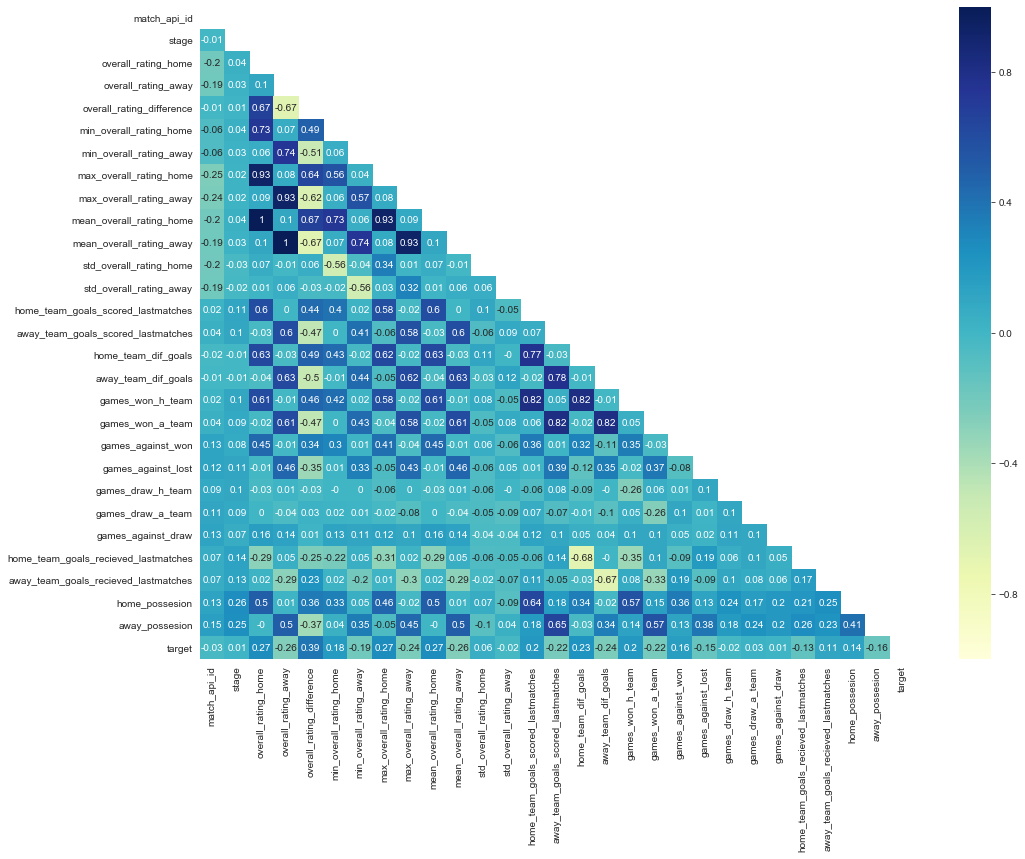

In [46]:
corrpplot = pplot.corr()
mask = np.zeros_like(corrpplot)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16,12))
    ax = sns.heatmap(round(corrpplot,2), annot=True,mask=mask, vmax=1 ,vmin = -1, cmap="YlGnBu")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show();

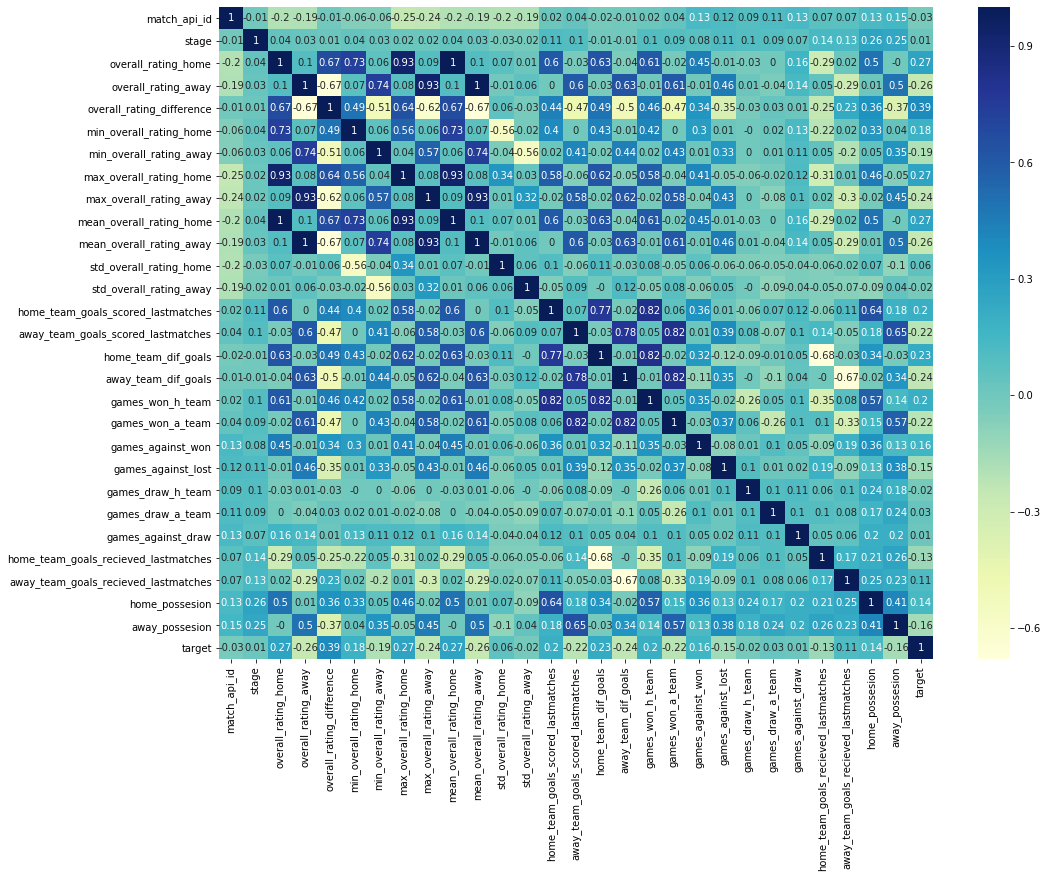

In [47]:
corrpplot = pplot.corr()
plt.figure(figsize=(16,12))
ax = sns.heatmap(round(corrpplot,2), annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show();

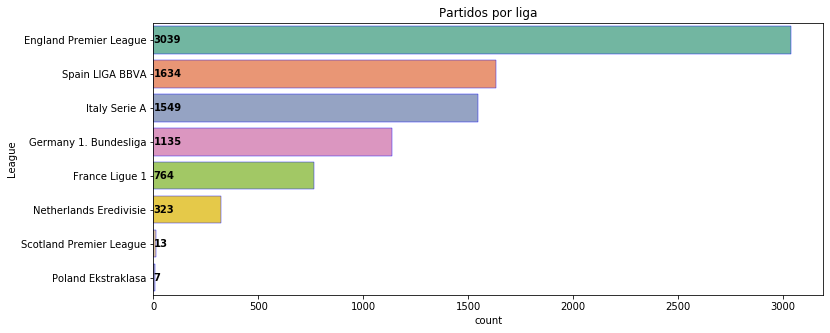

In [48]:
#lo primero que quiero visualizar es el número de partidos por liga, cuanta información tengo para mis modelos predictivos

plt.figure(figsize=(12,5))
ax = sns.countplot(y = matches["League"],order = matches["League"].value_counts().index,
                   linewidth = 0.4, 
                   edgecolor = "b" * matches["League"].nunique(), palette="Set2")

for a,b in enumerate(matches["League"].value_counts().values):
    ax.text(0.5, a, b, weight = "bold", ha='left', va='center',multialignment = 'left')
    
plt.title("Partidos por liga")
plt.show();

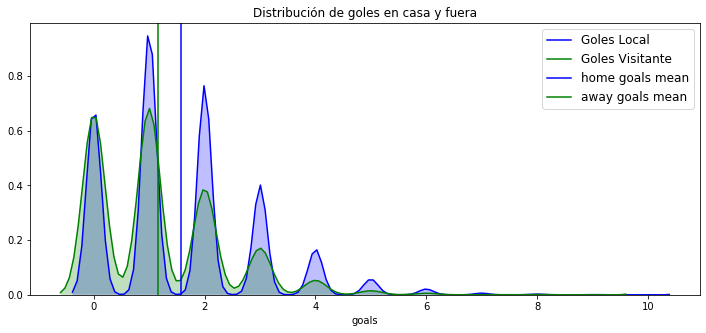

In [49]:
plt.figure(figsize=(12,5))
sns.kdeplot(matches["home_team_goal"],shade=True, color="b",label="Goles Local")
sns.kdeplot(matches["away_team_goal"],shade=True, color="g",label="Goles Visitante")
plt.axvline(matches["home_team_goal"].mean(),linestyle = "solid", color="b",label="home goals mean")
plt.axvline(matches["away_team_goal"].mean(),linestyle = "solid", color="g",label="away goals mean")
plt.legend(loc="best",prop = {"size" : 12})
plt.title("Distribución de goles en casa y fuera")
plt.xlabel("goals")
plt.show();

In [50]:
# "Melt" the dataset to "long-form" or "tidy" representation
matches2 = pd.melt(matches, "League", var_name="season")
matches2 = matches2[matches2['season']=="season"].rename({'season':'partidos'})
matches2['partidos'] = 1
matches2 = matches2.groupby(['League', 'value'], as_index=False)['partidos'].sum()
matches2

,League,value,partidos
0,England Premier League,2008/2009,380
1,England Premier League,2009/2010,380
2,England Premier League,2010/2011,379
3,England Premier League,2011/2012,380
4,England Premier League,2012/2013,380
5,England Premier League,2013/2014,380
6,England Premier League,2014/2015,380
7,England Premier League,2015/2016,380
8,France Ligue 1,2011/2012,4
9,France Ligue 1,2014/2015,380


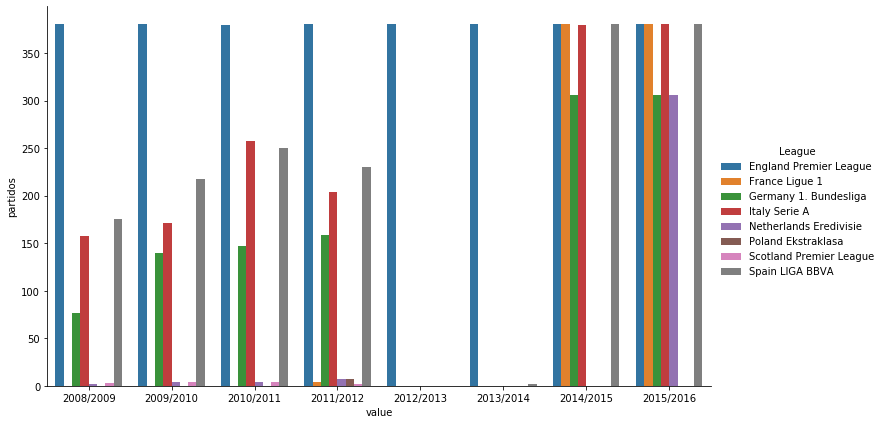

In [51]:
sns.catplot(x="value", y="partidos",
                hue="League",
                data=matches2, kind="bar",
                height=6, aspect=1.7);
del matches2,

#### Máximo de victorias por temporada, equipo y liga

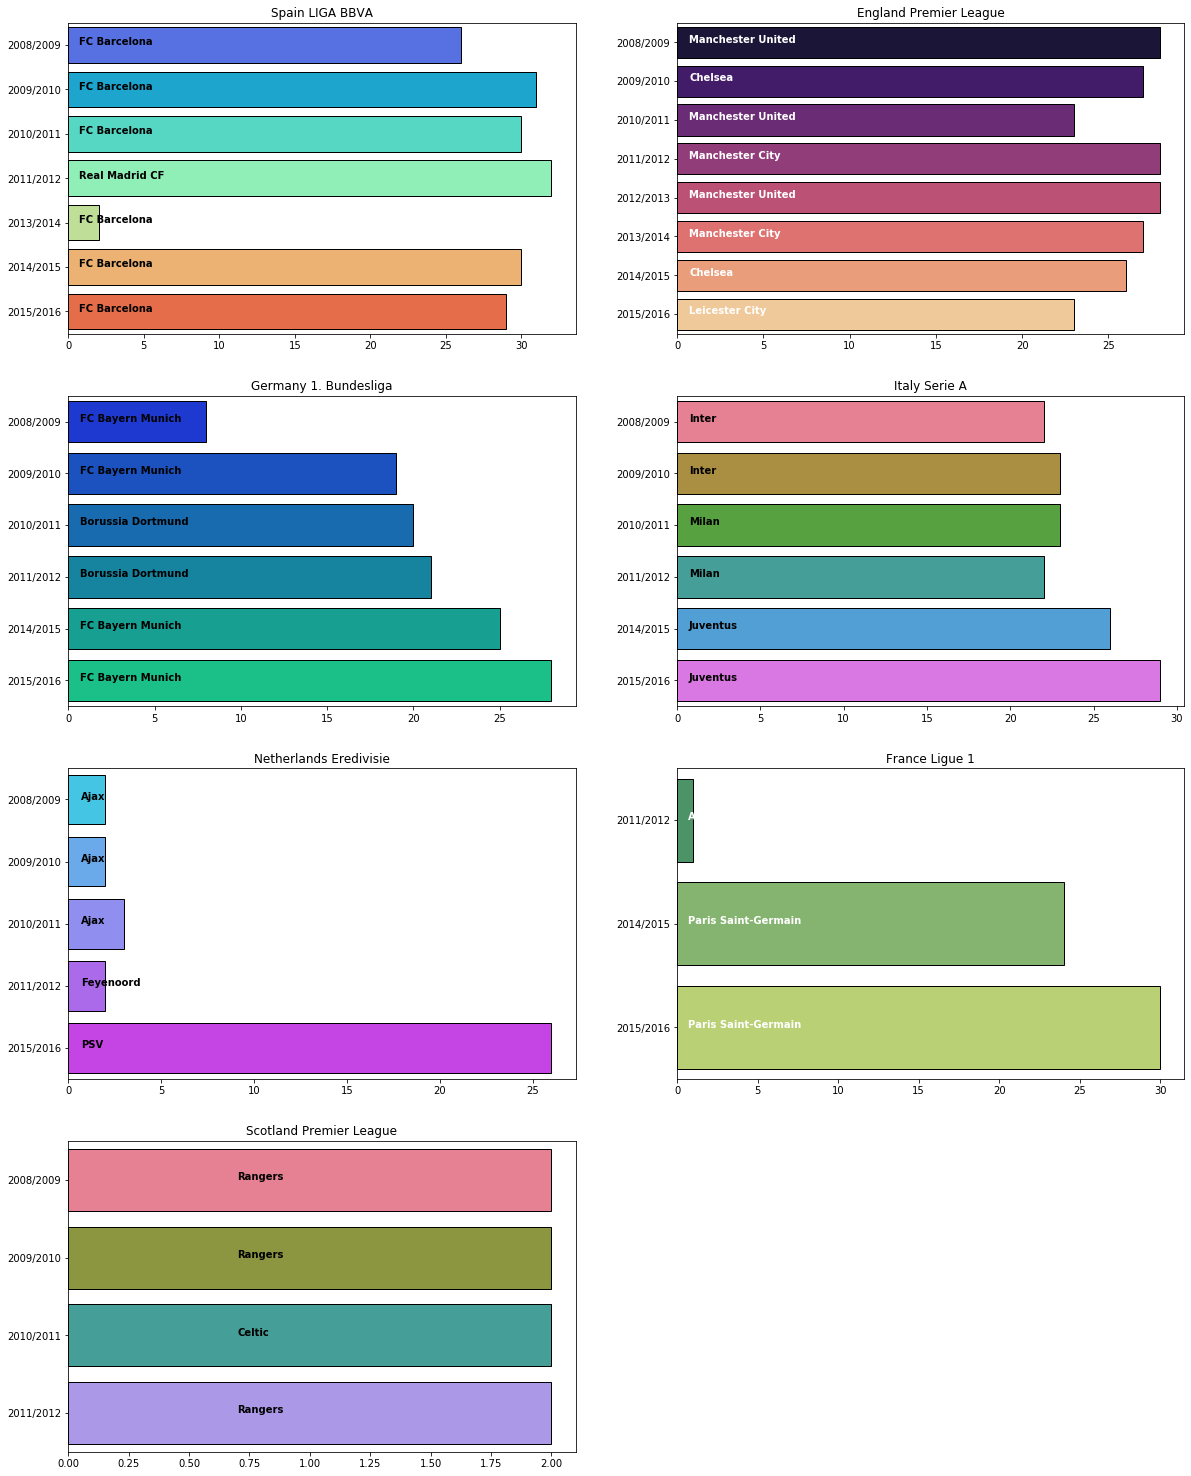

In [52]:
def label(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return data["Home_team_name"]
    elif data["away_team_goal"] > data["home_team_goal"]:
        return data["Away_team_name"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "EMPATE"


matches_plot = matches
matches_plot['win'] =  matches_plot.apply(lambda matches_plot:label(matches_plot),axis=1)
nw = matches_plot[["season","League","win"]]
nw["team"] = nw["win"]
nw = nw.groupby(["season","League","team"])["win"].count().reset_index().sort_values(by=["season","League","win"],ascending =False)
nw = nw[nw["team"] != "EMPATE"]
nw = nw.drop_duplicates(subset=["season","League"],keep="first").sort_values(by=["League","season"],ascending =True)

plt.figure(figsize=(20,40))
plt.subplot(625)
lg = nw[nw["League"] == "Netherlands Eredivisie"]
ax = sns.barplot(lg["win"],lg["season"],palette="cool",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold")
plt.title("Netherlands Eredivisie")
plt.xlabel("")
plt.ylabel("")

plt.subplot(622)
lg = nw[nw["League"] == "England Premier League"]
ax = sns.barplot(lg["win"],lg["season"],palette="magma",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold",color="white")
plt.title("England Premier League")
plt.xlabel("")
plt.ylabel("")

plt.subplot(621)
lg = nw[nw["League"] == 'Spain LIGA BBVA']
ax = sns.barplot(lg["win"],lg["season"],palette="rainbow",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold")
plt.title('Spain LIGA BBVA')
plt.xlabel("")
plt.ylabel("")

plt.subplot(626)
lg = nw[nw["League"] == 'France Ligue 1']
ax = sns.barplot(lg["win"],lg["season"],palette="summer",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold",color = "white")
plt.title('France Ligue 1')
plt.xlabel("")
plt.ylabel("")

plt.subplot(623)
lg = nw[nw["League"] == 'Germany 1. Bundesliga']
ax = sns.barplot(lg["win"],lg["season"],palette="winter",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold")
plt.title('Germany 1. Bundesliga')
plt.xlabel("")
plt.ylabel("")

plt.subplot(624)
lg = nw[nw["League"] == 'Italy Serie A']
ax = sns.barplot(lg["win"],lg["season"],palette="husl",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold")
plt.title('Italy Serie A')
plt.xlabel("")
plt.ylabel("")


plt.subplot(627)
lg = nw[nw["League"] == 'Scotland Premier League']
ax = sns.barplot(lg["win"],lg["season"],palette="husl",
                linewidth = 1 ,edgecolor = "k"*lg["season"].nunique())
for i,j in enumerate(lg["team"]):
    ax.text(.7,i,j,weight = "bold")
plt.title('Scotland Premier League')
plt.xlabel("")
plt.ylabel("")
plt.show()
del matches_plot, nw, lg;

#### Vamos a dejar preparada la información con las cuotas de apuestas para luego poder aplicarsela a nuestras predicciones:

In [53]:
bets = matches[betting_info]
for c in betting_info:
    bets[c] = bets[c].apply(lambda x: pd.to_numeric(x)).fillna(0)
bets

,match_api_id,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,489042,1.29,5.50,11.00,1.30,4.75,8.25,1.30,4.40,8.50,...,10.0,1.28,5.50,12.00,1.30,4.75,10.0,1.29,4.50,11.0
1,839802,1.25,5.50,15.00,1.22,5.50,12.50,1.22,5.30,11.00,...,12.0,1.22,6.00,15.00,1.23,5.50,12.0,1.22,5.50,13.0
2,1024845,1.40,4.50,8.50,1.37,4.60,8.25,1.33,4.60,7.80,...,10.0,1.40,4.75,9.50,1.35,4.50,8.5,1.40,4.33,8.5
3,1229300,1.22,6.50,13.00,1.22,6.50,11.00,1.25,5.60,10.00,...,13.0,1.25,6.50,13.00,1.22,6.50,11.0,1.25,6.00,10.0
4,1474518,1.53,4.33,7.00,1.53,4.00,6.25,1.50,4.00,6.10,...,6.0,1.55,4.50,6.25,0.00,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,1778265,4.33,3.25,1.95,3.80,3.40,1.95,3.80,3.45,1.90,...,0.0,4.50,3.50,1.92,0.00,0.00,0.0,0.00,0.00,0.0
8460,2030462,2.38,3.25,3.10,2.35,3.20,3.00,2.40,3.30,2.75,...,0.0,2.38,3.40,3.10,0.00,0.00,0.0,0.00,0.00,0.0
8461,530449,1.33,4.75,9.50,1.35,4.20,8.00,1.30,4.60,8.00,...,11.0,1.33,4.50,9.00,1.35,5.00,8.0,1.33,4.75,9.0
8462,530094,1.25,5.50,12.00,1.20,5.50,11.50,1.20,5.00,12.00,...,15.0,1.22,6.00,10.00,1.25,5.00,12.0,1.22,5.50,11.0


## Desarrollo de modelos predictivos

In [334]:
#Importamos las librerías necesarias
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, ParameterGrid, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

#Librerías para el desplegable de las casas de apuestas
from ipywidgets import widgets
from IPython.display import display

####  Filtramos la última temporada como conjunto de test a predecir. 

In [335]:
#matches.dtypes
#Jornada desde la que queremos hacer predicciones:
def train_test_split_season_stage(match, season, n_stages):
    '''Esta funcion hace el split de conjuntos, es mi train_test_split de Sklearn casero'''
    
    test = match[(match['season'] == '2015/2016') & (match['stage'] > n_stages) & (match['stage'] < 36) ]
    train = match[~match['match_api_id'].isin(test.match_api_id.unique())]
    X_test = test.drop(columns = {'date','season','stage','target', 'match_api_id'})
    y_test = test['target']
    X_train = train.drop(columns = {'date','season','stage','target', 'match_api_id'})
    y_train = train['target']
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test, test, train


In [336]:
def filter_season_Country(matches, country):
    '''Filtra los conjuntos por el país indicado. Si se quieren dejar temporadas fuera modificar codigo comentado'''
    
    temporadas = pd.Series(matches['season'].unique())
    excluimos_temporadas = np.array([])#,'2008/2009', '2009/2010', '2010/2011', '2011/2012'])#, '2012/2013'])
    selected_seasons = temporadas[~temporadas.isin(excluimos_temporadas)]
    #Filtramos
    match = matches[matches['season'].isin(np.array(selected_seasons))& (matches['Country'] == country)]
    match = match[match_labels].reset_index(drop=True)
    return match, country



In [337]:
def normalizar_conjuntos(X_train, X_test):
    '''normalizamos los conjuntos de datos para pasar por los algoritmos'''
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return X_train, X_test

In [338]:
def regresion_logistica(X_train, y_train, X_test, y_test):
    '''clasificador de regresión logística'''
    
    clasificador = LogisticRegression()
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    y_pred_p = clasificador.predict_proba(X_test)

    predicciones = pd.DataFrame({'real':y_test, 'pred':y_pred,
                                 'prob_-1': y_pred_p[:,0],'prob_0':y_pred_p[:,1], 'prob_1':y_pred_p[:,2]})
    predicciones['hit'] = np.where((predicciones['real']==predicciones['pred']), 1, 0)
    print('Accuracy en el modelo de regresión: ',sum(predicciones.hit)/len(predicciones))
    return y_pred, predicciones

#RANDOM FOREST
def Random_Forest(X_train, y_train, X_test, y_test, n_estimators, bootstrap, max_depth, max_features, min_samples_leaf,min_samples_split):
    '''clasificador Random Forest'''
    
    clasificador = RandomForestClassifier(n_estimators = n_estimators, bootstrap = bootstrap,max_depth = max_depth,
                                         max_features = max_features, min_samples_leaf = min_samples_leaf,
                                         min_samples_split = min_samples_split)
    clasificador.fit(X_train,y_train)
    y_pred=clasificador.predict(X_test)
    return y_pred, clasificador


#SVClassifier
def Support_Vector_Classification(X_train, y_train, X_test, y_test, kernel, C_param, gamma):
    '''clasificador SVC'''
    
    clasificador = SVC(kernel = kernel, C = C_param, gamma = gamma, probability=True)
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    return y_pred, clasificador

#XgBoost
def XGBoost_Clasificator(X_train, y_train, X_test, y_test, learning_rate, n_estimators):
    '''clasificdor Xgboost'''
    
    clasificador = XGBClassifier(learning_rate=learning_rate,n_estimators=n_estimators)
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    return y_pred, clasificador

#AdaBoost
def AdaBoost_Clasificator(X_train, y_train, X_test, y_test, learning_rate, n_estimators):
    '''Clasificador AdaBoost'''
    
    clasificador = AdaBoostClassifier(learning_rate = learning_rate, n_estimators = n_estimators)
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    return y_pred, clasificador

## KNeighbors Model
def Kneighbors_Clasificator(X_train, y_train, X_test, y_test, n_splits):
    '''clasificador Kneighbors'''
    
    seed = 42
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    clasificador = KNeighborsClassifier()
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    return y_pred, clasificador

## Gaussian Model
def Gaussian_Clasificator(X_train, y_train, X_test, y_test, n_splits):
    '''Clasificador Gausiano Naive Bayes'''
    
    seed = 42
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    clasificador = GaussianNB()
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    return y_pred


In [339]:
def Neuronal_Net_Classificator(X_train, y_train, X_test, y_test, batch_size, epochs, result):
    ''' función para ejecutar la red neuronal'''
    
    parada = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    batch_size = batch_size
    epochs = epochs
    steps_per_epoch = len(X_train)/batch_size
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=26, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid') ])

    optimizer = tf.keras.optimizers.Adagrad( lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch, validation_data=(X_test, y_test),  callbacks=[parada])

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print('\nAccuracy: %.2f' % (test_accuracy*100))

    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # Set the vertical range
    plt.show()

    #Matriz de confusion, 

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis=1)
    if not 1 in y_pred:
        y_pred[-1] = 1
    y_pred = [-1 if x==0 else 0 if x==1 else 1 for x in y_pred]
    y_pred = pd.get_dummies(y_pred)
    n = len(result) + 1
    try:
        matriz_confusion = multilabel_confusion_matrix(y_test, y_pred)
        print(matriz_confusion)
        result.loc[n] = ["Neuronal Net"] + [test_accuracy]+ [matriz_confusion[0][1][1]] + [matriz_confusion[1][1][1]] + [matriz_confusion[2][1][1]]
    except:
        result.loc[n] = ["Neuronal Net"] + [test_accuracy]+ [0] + [0] + [0]
    return y_pred, result

#### Creamos los dataframes en blanco que van a contener las comparativas de algoritmos

In [350]:
#Creamos df con Algoritmos y resultados:
result = pd.DataFrame(columns=('Algoritmo_Utilizado', 'Accuracy', 'Aciertos_H.Lose','Aciertos_H.Draw','Aciertos_H.Victory'))
comparable_results = pd.DataFrame(columns=('Algoritmo_Utilizado', 'Accuracy', 'Country'))

In [341]:
def resultados_modelo(y_test, y_pred, result, model_name):
    ''' función que devuelve resultados del modelo y los incluye en el dataframe de resultados'''
    
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test, y_pred))
    TP = np.diag(confusion_matrix(y_test, y_pred))
    n = len(result) + 1
    result.loc[n] = [model_name] + [metrics.accuracy_score(y_test, y_pred)]+ [TP[0]] + [TP[1]] + [TP[2]]
    return TP 

In [342]:
def models_for_each_country(X_train, X_test, y_train, y_test):
    '''Ejecutamos cada uno de los modelos para el conjunto de datos cargado. Creamos DF con los resultados'''
    
    result = pd.DataFrame(columns=('Algoritmo_Utilizado', 'Accuracy','Aciertos_H.Lose','Aciertos_H.Draw','Aciertos_H.Victory'))
    y_pred, predicciones = regresion_logistica(X_train, y_train, X_test, y_test)
    print("\nLogistic Regression")
    TP = resultados_modelo(y_test, y_pred, result, "Logistic Regression")
    y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 80, 2, 5, 10)
    print("\nRandom Forrest")
    TP = resultados_modelo(y_test, y_pred, result, "Random Forrest")
    y_pred, clasificador = Support_Vector_Classification(X_train, y_train, X_test, y_test, 'linear', 1.0, 0.01)
    print("\nSupport Vector Classification")
    TP = resultados_modelo(y_test, y_pred, result, "Support Vector Classification")
    y_pred, clasificador = XGBoost_Clasificator(X_train, y_train, X_test, y_test, 0.01,600)
    print("\nXGB Classifier")
    TP = resultados_modelo(y_test, y_pred, result, "XGB Classifier")
    y_pred, clasificador = AdaBoost_Clasificator(X_train, y_train, X_test, y_test, 0.01, 500)
    print("\nAdaBoost Classifier")
    TP = resultados_modelo(y_test, y_pred, result, "AdaBoost Classifier")
    y_pred, clasificador = Kneighbors_Clasificator(X_train, y_train, X_test, y_test, 2)
    print("\nK Neighbors Model")
    TP = resultados_modelo(y_test, y_pred, result, "K Neighbors Model")
    y_pred = Gaussian_Clasificator(X_train, y_train, X_test, y_test, 2)
    print("\nGaussian Model")
    TP = resultados_modelo(y_test, y_pred, result, "Gaussian Model")
    print("\nNeuronal Net")
    y_pred, result = Neuronal_Net_Classificator(X_train, y_train, X_test, y_test, 10, 150, result)
    
    return result

In [343]:
def Confusion_Matrix(y_test, y_pred):
    '''Representa gráficamente la matriz de confusión'''
    
    cm = confusion_matrix(y_test, y_pred)
    index = ['Away_Victory','Draw','Home_Victory']  
    columns = ['Away_Victory','Draw','Home_Victory']  
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(10,6))  
    ax = sns.heatmap(cm_df, annot=True, cmap="Greens")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Valor Pronosticado', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('Valor Real', fontsize = 15) # y-axis label with fontsize 15
    plt.show();

#### Lista de casas de apuestas que va a tener el desplegable

In [344]:
lista = ['Bet365', 'Bet&Win', 'Interwetten',   'William Hill','Ladbrokes','Pinnacle', 'VcBet']
#w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
#display(w)


In [345]:
def filter_country_selected(w, matches):
    '''En función del valor seleccionado en el desplegable filtra por las cuotas de la casa elegida'''
    
    if len(w.value) > 0:
        if w.value[0] == 'Bet365':
            a = ['match_api_id','B365H', 'B365D', 'B365A'] ;c = w.value
        elif w.value[0] == 'Bet&Win':
            a = ['match_api_id','BWH', 'BWD', 'BWA'] ;c = w.value[0]
        elif w.value[0] == 'William Hill':
            a = ['match_api_id','WHH', 'WHD', 'WHA'] ;c = w.value[0]
        elif w.value[0] == 'VcBet':
            a = ['match_api_id','VCH', 'VCD', 'VCA'] ;c = w.value[0]
        elif w.value[0] == 'Pinnacle':
            a = ['match_api_id','PSH', 'PSD', 'PSA'] ;c = w.value[0]
        elif w.value[0] == 'Interwetten':
            a = ['match_api_id','IWH', 'IWD', 'IWA'] ;c = w.value[0]
        elif w.value[0] == 'Ladbrokes':
            a = ['match_api_id','LBH', 'LBD', 'LBA'] ;c = w.value[0]
        else:
            a = ['match_api_id','B365H', 'B365D', 'B365A']
            c = 'Bet365'
    else: 
        a = ['match_api_id','B365H', 'B365D', 'B365A']
        c = 'Bet365'
    
    return  a , c


In [346]:
def apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, bet_amount ):
    ''' aplicamos el modelo elegido a las apuestas elegidas con el importe introducido en bet_amount'''
    
    test['y_pred'] = y_pred
    test['probab_lose'] = clasificador.predict_proba(X_test)[:,0]
    test['probab_draw'] = clasificador.predict_proba(X_test)[:,1]
    test['probab_win'] = clasificador.predict_proba(X_test)[:,2]

    test = test.merge(bets[columnas], right_on='match_api_id',left_on='match_api_id', 
                     how = 'left').rename(columns={columnas[1]:'CouteWinH',columnas[2]:'CouteDrawH',columnas[3]:'CouteLoseH'})
    test = test.merge(matches[['match_api_id', 'Country', 'League', 'Home_team_name','Away_team_name']], 
                      right_on='match_api_id',left_on='match_api_id', how = 'left')
    ### En cada ejemplo apostaremos la cantidad indicada e.x. 100€ a cada partido
    bet_amount = bet_amount
    test['potential_outcome'] = np.where(test.y_pred == 1,test['CouteWinH']*bet_amount,np.where(test.y_pred == 0,
                                                                    test['CouteDrawH']*bet_amount,test['CouteLoseH']*bet_amount ))
    test['real_outcome'] = np.where(test.y_pred == test.target, test['potential_outcome'] - bet_amount, bet_amount*(-1))
    columns = ['lose','draw', 'win']
    strategies = [0.66, 0.74, 0.8]
    strat = []
    for i in strategies:
        name = 'real_outcome_strategy_' + str(i*100) + "%"
        test[name] = np.where(test[['probab_' + p for p in columns]].max(axis=1) >= i , test['real_outcome'],0)
    print(casa_apuestas,"\n")    
    print("Confiamos en todas nuestras predicciones: €", test['real_outcome'].sum())
    print('Yield % ', round((test['real_outcome'].sum() / (test['real_outcome'].count() * bet_amount))*100,2)
         ,'Total Apostado: ',test['real_outcome'].count() * bet_amount)
    print('\nEstrategia A, probabilidad superior al 66%: €',test['real_outcome_strategy_66.0%'].sum())
    print('Yield % ', round(test['real_outcome_strategy_66.0%'].sum() / (test.target[test['real_outcome_strategy_66.0%'] != 0
       ].count()* bet_amount)*100,2), 'Total Apostado: ',test.target[test['real_outcome_strategy_66.0%'] != 0
       ].count()* bet_amount)
    print('\nEstrategia B, probabilidad superior al 74%: €',test['real_outcome_strategy_74.0%'].sum())
    print('Yield % ', round(test['real_outcome_strategy_74.0%'].sum() / (test.target[test['real_outcome_strategy_74.0%'] != 0
       ].count()* bet_amount)*100,2), 'Total Apostado: ',test.target[test['real_outcome_strategy_74.0%'] != 0
       ].count()* bet_amount)
    print('\nEstrategia C, probabilidad superior al 80%: €',round(test['real_outcome_strategy_80.0%'].sum(),2))
    print('Yield % ', round(test['real_outcome_strategy_80.0%'].sum() / (test.target[test['real_outcome_strategy_80.0%'] != 0
       ].count() * bet_amount)*100,2), 'Total Apostado: ',test.target[test['real_outcome_strategy_80.0%'] != 0
       ].count() * bet_amount)
    test.to_excel(ruta +"testbet.xlsx", index = False)

## Aplicamos los modelos en cada una de las ligas

### LIGA INGLESA

In [351]:
match, country  = filter_season_Country(matches, 'England')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 19)
X_train, X_test = normalizar_conjuntos(X_train, X_test)

(2879, 26) (160, 26) (2879,) (160,)


Accuracy en el modelo de regresión:  0.4625

Logistic Regression
Accuracy: 0.4625
              precision    recall  f1-score   support

          -1       0.43      0.41      0.42        49
           0       0.25      0.02      0.04        43
           1       0.49      0.78      0.60        68

    accuracy                           0.46       160
   macro avg       0.39      0.40      0.35       160
weighted avg       0.40      0.46      0.39       160

[[20  3 26]
 [12  1 30]
 [15  0 53]]

Random Forrest
Accuracy: 0.45625
              precision    recall  f1-score   support

          -1       0.44      0.35      0.39        49
           0       0.22      0.05      0.08        43
           1       0.48      0.79      0.60        68

    accuracy                           0.46       160
   macro avg       0.38      0.40      0.35       160
weighted avg       0.40      0.46      0.39       160

[[17  4 28]
 [11  2 30]
 [11  3 54]]

Support Vector Classification
Accuracy: 0.45
  

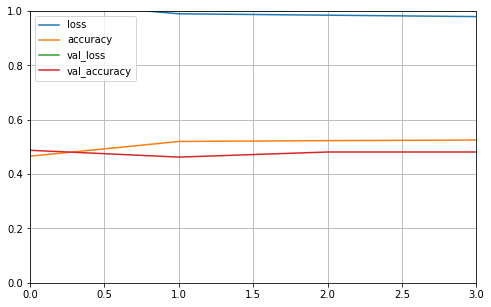

[[[ 83  28]
  [ 27  22]]

 [[116   1]
  [ 43   0]]

 [[ 38  54]
  [ 13  55]]]


In [352]:
result = models_for_each_country(X_train, X_test, y_train, y_test)

In [353]:
result['Hits'] =  result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result.sort_values(by = 'Accuracy', ascending = False)
result['Country'] = country
comparable_results = pd.concat([comparable_results,result[['Algoritmo_Utilizado', 'Accuracy', 'Country']]])

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits
8,Neuronal Net,0.48125,22,0,55,77
1,Logistic Regression,0.46250,20,1,53,74
2,Random Forrest,0.45625,17,2,54,73
3,Support Vector Classification,0.45000,18,0,54,72
4,XGB Classifier,0.44375,15,1,55,71
5,AdaBoost Classifier,0.44375,16,0,55,71
7,Gaussian Model,0.41875,22,5,40,67
6,K Neighbors Model,0.40625,18,8,39,65


In [355]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…


 Random Forrest 0.4625


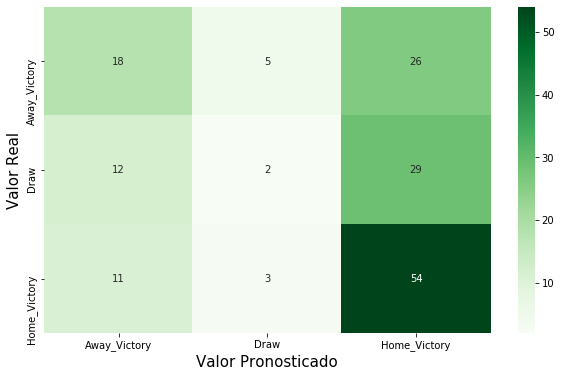

In [356]:
y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 80, 2, 5, 10)
print('\n Random Forrest', metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [357]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

Bet365 

Confiamos en todas nuestras predicciones: € -1981.0
Yield %  -12.38 Total Apostado:  16000

Estrategia A, probabilidad superior al 66%: € -403.0
Yield %  -19.19 Total Apostado:  2100

Estrategia B, probabilidad superior al 74%: € -177.0
Yield %  -16.09 Total Apostado:  1100

Estrategia C, probabilidad superior al 80%: € -65.0
Yield %  -10.83 Total Apostado:  600


### LIGA ITALIANA

In [358]:
match, country = filter_season_Country(matches, 'Italy')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 19)

X_train, X_test = normalizar_conjuntos(X_train, X_test)

(1389, 26) (160, 26) (1389,) (160,)


Accuracy en el modelo de regresión:  0.525

Logistic Regression
Accuracy: 0.525
              precision    recall  f1-score   support

          -1       0.39      0.59      0.47        37
           0       0.50      0.04      0.08        47
           1       0.61      0.79      0.69        76

    accuracy                           0.53       160
   macro avg       0.50      0.48      0.41       160
weighted avg       0.52      0.53      0.46       160

[[22  2 13]
 [19  2 26]
 [16  0 60]]

Random Forrest
Accuracy: 0.55625
              precision    recall  f1-score   support

          -1       0.48      0.57      0.52        37
           0       1.00      0.02      0.04        47
           1       0.58      0.88      0.70        76

    accuracy                           0.56       160
   macro avg       0.69      0.49      0.42       160
weighted avg       0.68      0.56      0.47       160

[[21  0 16]
 [14  1 32]
 [ 9  0 67]]

Support Vector Classification
Accuracy: 0.51875
 

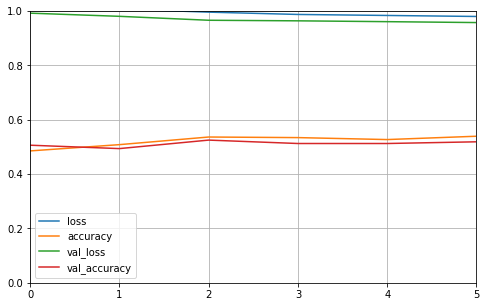

[[[ 87  36]
  [ 15  22]]

 [[113   0]
  [ 46   1]]

 [[ 44  40]
  [ 15  61]]]


In [359]:
result = models_for_each_country(X_train, X_test, y_train, y_test)

In [360]:
result['Hits'] = result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result.sort_values(by = 'Accuracy', ascending = False)
result['Country'] = country
comparable_results = pd.concat([comparable_results,result[['Algoritmo_Utilizado', 'Accuracy', 'Country']]])

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits
2,Random Forrest,0.55625,21,1,67,89
5,AdaBoost Classifier,0.55000,22,0,66,88
1,Logistic Regression,0.52500,22,2,60,84
8,Neuronal Net,0.51875,22,1,61,84
3,Support Vector Classification,0.51875,23,0,60,83
7,Gaussian Model,0.51875,24,5,54,83
4,XGB Classifier,0.50000,16,4,60,80
6,K Neighbors Model,0.46875,21,9,45,75


In [361]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…


 Random Forest Clasificator 0.5625


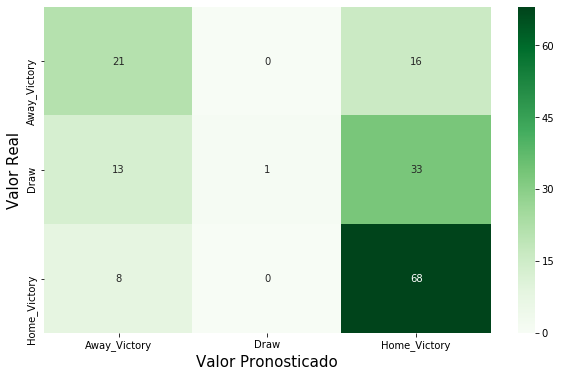

In [362]:
y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 80, 2, 5, 10)
print('\n Random Forest Clasificator', metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [363]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

Bet&Win 

Confiamos en todas nuestras predicciones: € 1152.0
Yield %  7.2 Total Apostado:  16000

Estrategia A, probabilidad superior al 66%: € 278.0
Yield %  11.58 Total Apostado:  2400

Estrategia B, probabilidad superior al 74%: € 49.999999999999986
Yield %  8.33 Total Apostado:  600

Estrategia C, probabilidad superior al 80%: € 33.0
Yield %  33.0 Total Apostado:  100


### LIGA ALEMANA

In [364]:
match, country = filter_season_Country(matches, 'Germany')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 18)

X_train, X_test = normalizar_conjuntos(X_train, X_test)

(991, 26) (144, 26) (991,) (144,)


Accuracy en el modelo de regresión:  0.5277777777777778

Logistic Regression
Accuracy: 0.5277777777777778
              precision    recall  f1-score   support

          -1       0.48      0.51      0.49        41
           0       0.00      0.00      0.00        36
           1       0.56      0.82      0.67        67

    accuracy                           0.53       144
   macro avg       0.35      0.44      0.39       144
weighted avg       0.40      0.53      0.45       144

[[21  1 19]
 [12  0 24]
 [11  1 55]]

Random Forrest
Accuracy: 0.5
              precision    recall  f1-score   support

          -1       0.47      0.41      0.44        41
           0       0.00      0.00      0.00        36
           1       0.51      0.82      0.63        67

    accuracy                           0.50       144
   macro avg       0.33      0.41      0.36       144
weighted avg       0.37      0.50      0.42       144

[[17  0 24]
 [ 8  0 28]
 [11  1 55]]

Support Vector Classificati

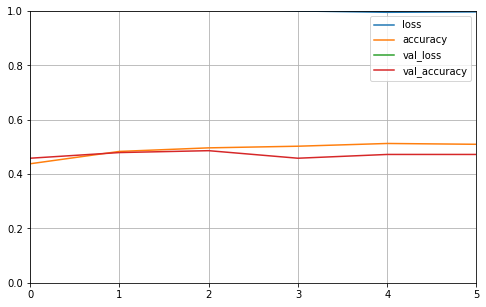

[[[ 75  28]
  [ 23  18]]

 [[104   4]
  [ 36   0]]

 [[ 33  44]
  [ 17  50]]]


In [365]:
result = models_for_each_country(X_train, X_test, y_train, y_test)


In [366]:
result['Hits'] = result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result.sort_values(by = 'Accuracy', ascending = False)
result['Country'] = country
comparable_results = pd.concat([comparable_results,result[['Algoritmo_Utilizado', 'Accuracy', 'Country']]])

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits
1,Logistic Regression,0.527778,21,0,55,76
3,Support Vector Classification,0.527778,20,0,56,76
2,Random Forrest,0.500000,17,0,55,72
4,XGB Classifier,0.486111,17,1,52,70
5,AdaBoost Classifier,0.479167,14,0,55,69
8,Neuronal Net,0.472222,18,0,50,68
7,Gaussian Model,0.458333,19,13,34,66
6,K Neighbors Model,0.402778,23,4,31,58


In [367]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…


 SVM 0.5277777777777778


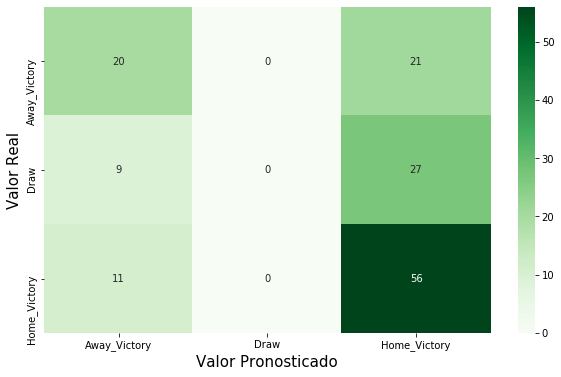

In [368]:
y_pred, clasificador = Support_Vector_Classification(X_train, y_train, X_test, y_test, 'linear', 1.0, 0.01)
print('\n SVM', metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [369]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

Interwetten 

Confiamos en todas nuestras predicciones: € -14.0
Yield %  -0.1 Total Apostado:  14400

Estrategia A, probabilidad superior al 66%: € 0.0
Yield %  nan Total Apostado:  0

Estrategia B, probabilidad superior al 74%: € 0.0
Yield %  nan Total Apostado:  0

Estrategia C, probabilidad superior al 80%: € 0.0
Yield %  nan Total Apostado:  0


### LIGA FRANCESA

In [370]:
match, country = filter_season_Country(matches, 'France')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 20)

X_train, X_test = normalizar_conjuntos(X_train, X_test)

(614, 26) (150, 26) (614,) (150,)


Accuracy en el modelo de regresión:  0.52

Logistic Regression
Accuracy: 0.52
              precision    recall  f1-score   support

          -1       0.54      0.45      0.49        44
           0       0.35      0.15      0.21        40
           1       0.54      0.79      0.64        66

    accuracy                           0.52       150
   macro avg       0.48      0.46      0.45       150
weighted avg       0.49      0.52      0.48       150

[[20  4 20]
 [10  6 24]
 [ 7  7 52]]

Random Forrest
Accuracy: 0.56
              precision    recall  f1-score   support

          -1       0.56      0.41      0.47        44
           0       0.67      0.15      0.24        40
           1       0.55      0.91      0.69        66

    accuracy                           0.56       150
   macro avg       0.59      0.49      0.47       150
weighted avg       0.58      0.56      0.51       150

[[18  3 23]
 [ 8  6 26]
 [ 6  0 60]]

Support Vector Classification
Accuracy: 0.526666666666

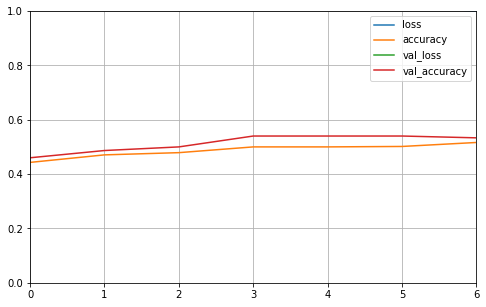

[[[ 84  22]
  [ 20  24]]

 [[109   1]
  [ 40   0]]

 [[ 36  48]
  [ 11  55]]]


In [371]:
result = models_for_each_country(X_train, X_test, y_train, y_test)

In [372]:
result['Hits'] = result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result.sort_values(by = 'Accuracy', ascending = False)
result['Country'] = country
comparable_results = pd.concat([comparable_results,result[['Algoritmo_Utilizado', 'Accuracy', 'Country']]])

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits
2,Random Forrest,0.560000,18,6,60,84
8,Neuronal Net,0.533333,24,0,55,79
3,Support Vector Classification,0.526667,21,0,58,79
1,Logistic Regression,0.520000,20,6,52,78
7,Gaussian Model,0.513333,27,7,43,77
4,XGB Classifier,0.493333,17,9,48,74
5,AdaBoost Classifier,0.493333,12,1,61,74
6,K Neighbors Model,0.380000,22,7,28,57


In [373]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…


 Random Forest 0.5066666666666667


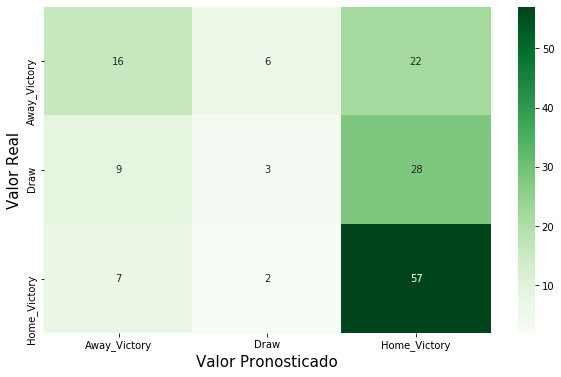

In [374]:
y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 80, 2, 5, 10)
print('\n Random Forest', metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [375]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

Interwetten 

Confiamos en todas nuestras predicciones: € 447.0
Yield %  2.98 Total Apostado:  15000

Estrategia A, probabilidad superior al 66%: € 17.0
Yield %  1.13 Total Apostado:  1500

Estrategia B, probabilidad superior al 74%: € 102.0
Yield %  25.5 Total Apostado:  400

Estrategia C, probabilidad superior al 80%: € 82.0
Yield %  27.33 Total Apostado:  300


### LIGA HOLANDESA

In [376]:
match, country = filter_season_Country(matches, 'Netherlands')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 19)

X_train, X_test = normalizar_conjuntos(X_train, X_test)

(188, 26) (135, 26) (188,) (135,)


Accuracy en el modelo de regresión:  0.42962962962962964

Logistic Regression
Accuracy: 0.42962962962962964
              precision    recall  f1-score   support

          -1       0.47      0.35      0.40        49
           0       0.16      0.12      0.14        32
           1       0.50      0.69      0.58        54

    accuracy                           0.43       135
   macro avg       0.38      0.39      0.37       135
weighted avg       0.41      0.43      0.41       135

[[17 13 19]
 [10  4 18]
 [ 9  8 37]]

Random Forrest
Accuracy: 0.4962962962962963
              precision    recall  f1-score   support

          -1       0.58      0.37      0.45        49
           0       0.20      0.03      0.05        32
           1       0.48      0.89      0.63        54

    accuracy                           0.50       135
   macro avg       0.42      0.43      0.38       135
weighted avg       0.45      0.50      0.43       135

[[18  3 28]
 [ 8  1 23]
 [ 5  1 48]]

Support Ve

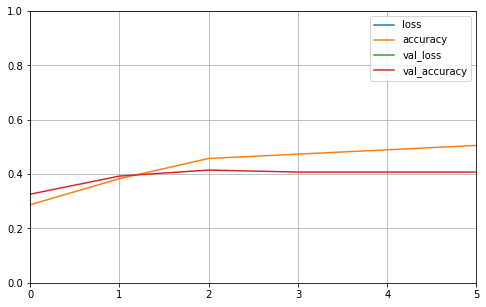

[[[ 84   2]
  [ 47   2]]

 [[102   1]
  [ 32   0]]

 [[  4  77]
  [  1  53]]]


In [377]:
result = models_for_each_country(X_train, X_test, y_train, y_test)

In [378]:
result['Hits'] = result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result['Country'] = country
result.sort_values(by = 'Accuracy', ascending = False)
comparable_results = pd.concat([comparable_results,result[['Algoritmo_Utilizado', 'Accuracy', 'Country']]])

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits,Country
6,K Neighbors Model,0.540741,26,9,38,73,Netherlands
2,Random Forrest,0.496296,18,1,48,67,Netherlands
4,XGB Classifier,0.496296,21,4,42,67,Netherlands
7,Gaussian Model,0.496296,22,7,38,67,Netherlands
5,AdaBoost Classifier,0.466667,13,6,44,63,Netherlands
1,Logistic Regression,0.429630,17,4,37,58,Netherlands
3,Support Vector Classification,0.429630,18,3,37,58,Netherlands
8,Neuronal Net,0.407407,2,0,53,55,Netherlands


In [379]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…


 K-Nearest Neighbours Classifier 0.5407407407407407


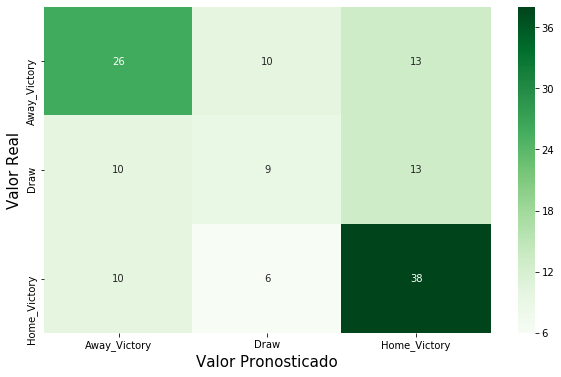

In [380]:
y_pred, clasificador = Kneighbors_Clasificator(X_train, y_train, X_test, y_test, 200)
print('\n K-Nearest Neighbours Classifier', metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [381]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

Interwetten 

Confiamos en todas nuestras predicciones: € 1426.0
Yield %  10.56 Total Apostado:  13500

Estrategia A, probabilidad superior al 66%: € -616.0
Yield %  -13.69 Total Apostado:  4500

Estrategia B, probabilidad superior al 74%: € -616.0
Yield %  -13.69 Total Apostado:  4500

Estrategia C, probabilidad superior al 80%: € -616.0
Yield %  -13.69 Total Apostado:  4500


### LIGA ESPAÑOLA

In [389]:
match, country = filter_season_Country(matches, 'Spain')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 18)

X_train, X_test = normalizar_conjuntos(X_train, X_test)

(1464, 26) (170, 26) (1464,) (170,)


Accuracy en el modelo de regresión:  0.5352941176470588

Logistic Regression
Accuracy: 0.5352941176470588
              precision    recall  f1-score   support

          -1       0.48      0.50      0.49        44
           0       0.33      0.05      0.08        43
           1       0.57      0.81      0.67        83

    accuracy                           0.54       170
   macro avg       0.46      0.45      0.41       170
weighted avg       0.49      0.54      0.47       170

[[22  0 22]
 [12  2 29]
 [12  4 67]]

Random Forrest
Accuracy: 0.5764705882352941
              precision    recall  f1-score   support

          -1       0.62      0.48      0.54        44
           0       0.00      0.00      0.00        43
           1       0.57      0.93      0.71        83

    accuracy                           0.58       170
   macro avg       0.40      0.47      0.42       170
weighted avg       0.44      0.58      0.49       170

[[21  1 22]
 [ 8  0 35]
 [ 5  1 77]]

Support Vect

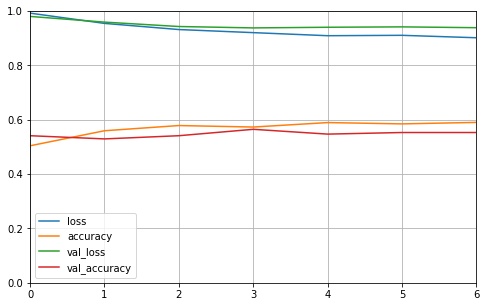

[[[105  21]
  [ 23  21]]

 [[126   1]
  [ 43   0]]

 [[ 33  54]
  [ 10  73]]]


In [390]:
result = models_for_each_country(X_train, X_test, y_train, y_test)

In [391]:
result['Hits'] = result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result.sort_values(by = 'Accuracy', ascending = False)
result['Country'] = country
comparable_results = pd.concat([comparable_results,result[['Algoritmo_Utilizado', 'Accuracy', 'Country']]])

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits
2,Random Forrest,0.576471,21,0,77,98
5,AdaBoost Classifier,0.570588,21,0,76,97
8,Neuronal Net,0.552941,21,0,73,94
3,Support Vector Classification,0.552941,21,0,73,94
1,Logistic Regression,0.535294,22,2,67,91
6,K Neighbors Model,0.511765,25,10,52,87
4,XGB Classifier,0.505882,21,4,61,86
7,Gaussian Model,0.488235,20,17,46,83


In [392]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…


 Ada Boost Classifier 0.5705882352941176


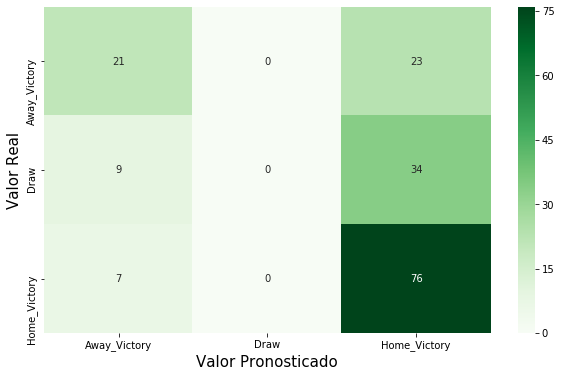

In [393]:
y_pred, clasificador = AdaBoost_Clasificator(X_train, y_train, X_test, y_test, 0.01, 500)
print('\n Ada Boost Classifier', metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [394]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

('Bet365',) 

Confiamos en todas nuestras predicciones: € 24.0
Yield %  0.14 Total Apostado:  17000

Estrategia A, probabilidad superior al 66%: € 0.0
Yield %  nan Total Apostado:  0

Estrategia B, probabilidad superior al 74%: € 0.0
Yield %  nan Total Apostado:  0

Estrategia C, probabilidad superior al 80%: € 0.0
Yield %  nan Total Apostado:  0


#### Most Predictable League

In [396]:
comparable_results.sort_values(by = 'Accuracy', ascending = False).head(10)

,Algoritmo_Utilizado,Accuracy,Country
2,Random Forrest,0.576471,Spain
5,AdaBoost Classifier,0.570588,Spain
2,Random Forrest,0.560000,France
2,Random Forrest,0.556250,Italy
8,Neuronal Net,0.552941,Spain
3,Support Vector Classification,0.552941,Spain
5,AdaBoost Classifier,0.550000,Italy
6,K Neighbors Model,0.540741,Netherlands
1,Logistic Regression,0.535294,Spain
8,Neuronal Net,0.533333,France


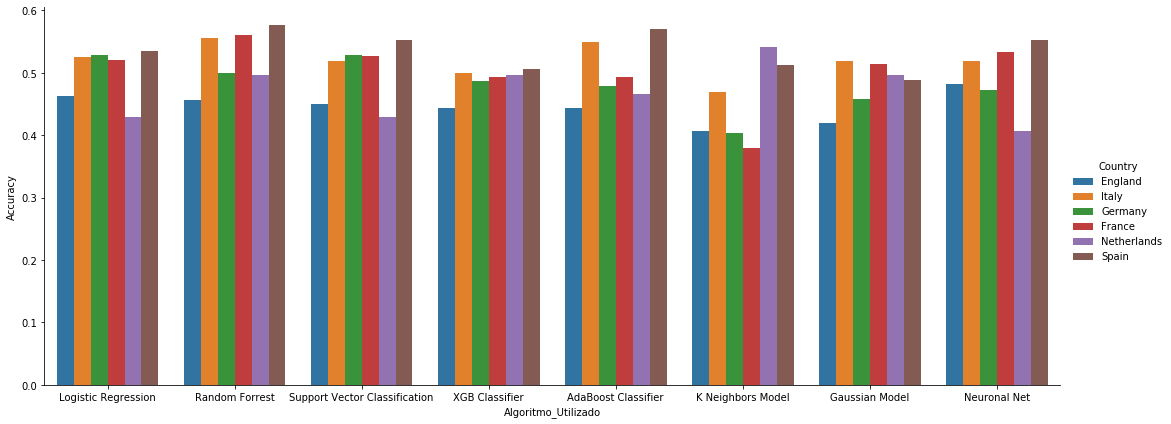

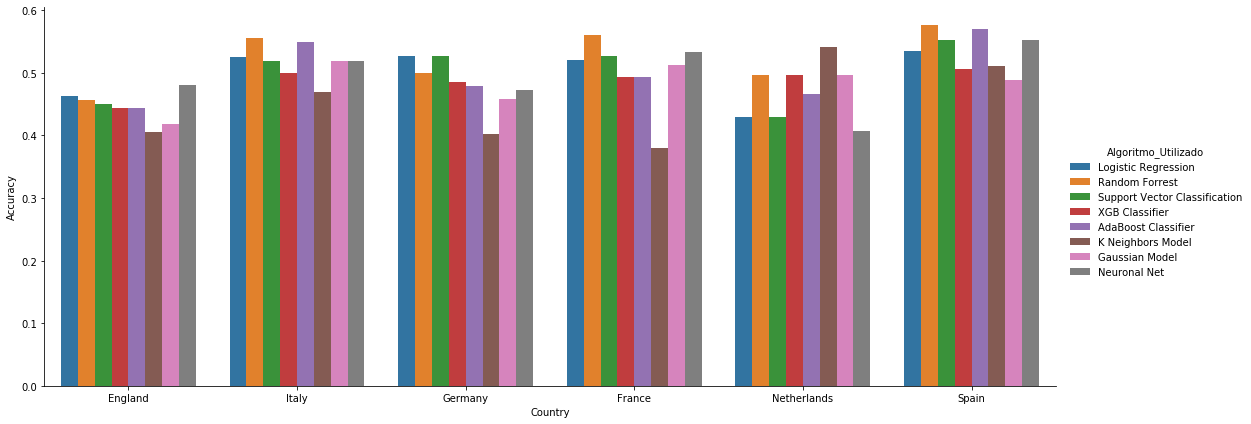

In [397]:
sns.catplot(x="Algoritmo_Utilizado", y="Accuracy", hue="Country", data=comparable_results, kind="bar", height=6, aspect=2.5)
sns.catplot(x="Country", y="Accuracy", hue="Algoritmo_Utilizado", data=comparable_results, kind="bar", height=6, aspect=2.5);

### Models Results (Spain)

Accuracy en el modelo de regresión:  0.5352941176470588

Logistic Regression
Accuracy: 0.5352941176470588
              precision    recall  f1-score   support

          -1       0.48      0.50      0.49        44
           0       0.33      0.05      0.08        43
           1       0.57      0.81      0.67        83

    accuracy                           0.54       170
   macro avg       0.46      0.45      0.41       170
weighted avg       0.49      0.54      0.47       170

[[22  0 22]
 [12  2 29]
 [12  4 67]]

Random Forrest
Accuracy: 0.5705882352941176
              precision    recall  f1-score   support

          -1       0.58      0.50      0.54        44
           0       0.00      0.00      0.00        43
           1       0.58      0.90      0.70        83

    accuracy                           0.57       170
   macro avg       0.39      0.47      0.41       170
weighted avg       0.43      0.57      0.48       170

[[22  0 22]
 [10  0 33]
 [ 6  2 75]]

Support Vect

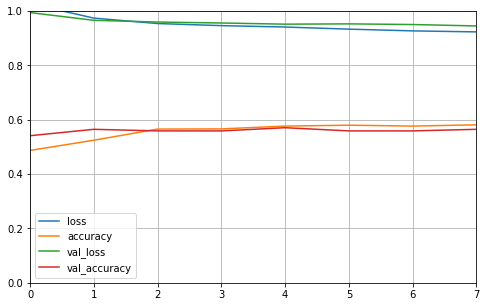

[[[103  23]
  [ 20  24]]

 [[126   1]
  [ 43   0]]

 [[ 37  50]
  [ 11  72]]]


In [398]:
result = models_for_each_country(X_train, X_test, y_train, y_test)

### Grid Search Hyperparameters Random Forest

In [399]:
# Grid Search# Grid Search
parameters = {'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12], 'n_estimators': [200, 300,400, 500]}
grid = GridSearchCV(RandomForestClassifier(),parameters,refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)
grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "Random Forest Grid Search")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              mi...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                  

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

Accuracy: 0.5705882352941176
              precision    recall  f1-score   support

          -1       0.59      0.50      0.54        44
           0       0.00      0.00      0.00        43
           1       0.57      0.90      0.70        83

    accuracy                           0.57       170
   macro avg       0.39      0.47      0.41       170
weighted avg       0.43      0.57      0.48       170

[[22  0 22]
 [ 8  0 35]
 [ 7  1 75]]



Random Forrest 0.5647058823529412
Accuracy: 0.5647058823529412
              precision    recall  f1-score   support

          -1       0.57      0.48      0.52        44
           0       0.00      0.00      0.00        43
           1       0.57      0.90      0.70        83

    accuracy                           0.56       170
   macro avg       0.38      0.46      0.41       170
weighted avg       0.43      0.56      0.48       170

[[21  1 22]
 [ 9  0 34]
 [ 7  1 75]]


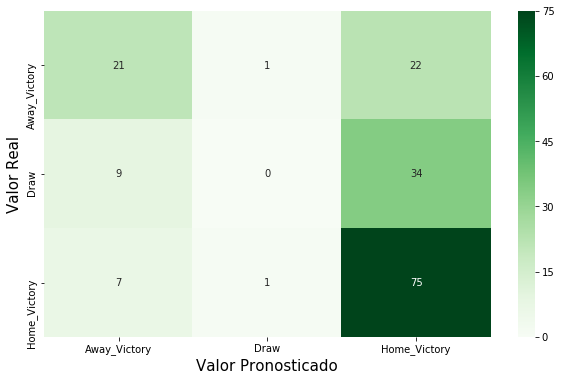

In [400]:
#Random_Forest(X_train, y_train, X_test, y_test, n_estimators, bootstrap, max_depth, max_features, min_samples_leaf,min_samples_split)
y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 110, 2, 4, 10)
print("\nRandom Forrest" , metrics.accuracy_score(y_test, y_pred))
TP = resultados_modelo(y_test, y_pred, result, "Random Forest Parametros Tuneados")
Confusion_Matrix(y_test, y_pred)

### Light Random Forest, vamos a podar el número de variables predictivas

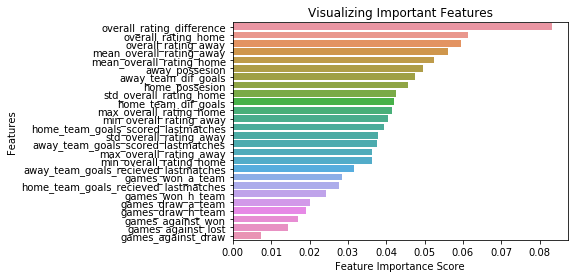

In [401]:
#Importancia características
feature_imp = pd.Series(clasificador.feature_importances_,index= train.drop(
    columns = {'date','season','stage','target', 'match_api_id'}).columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index);
# Add labels to your graph
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title("Visualizing Important Features");

Accuracy: 0.5588235294117647
              precision    recall  f1-score   support

          -1       0.54      0.48      0.51        44
           0       0.00      0.00      0.00        43
           1       0.57      0.89      0.69        83

    accuracy                           0.56       170
   macro avg       0.37      0.46      0.40       170
weighted avg       0.42      0.56      0.47       170

[[21  0 23]
 [10  0 33]
 [ 8  1 74]]


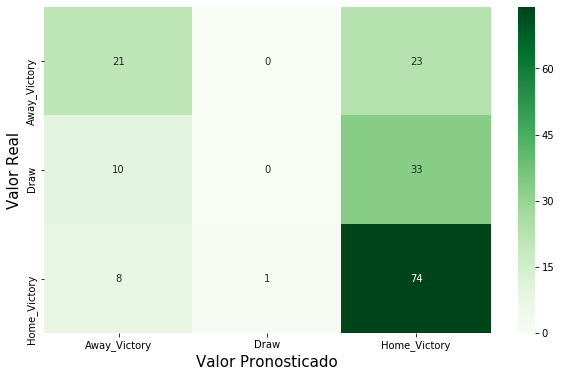

In [402]:
# Vamos a lanzar el modelo nuevamente pero dejando de lado las características menos importantes:
X_train_2 = train.drop(columns = {'date','season','stage','target', 'match_api_id', 'games_draw_h_team', 'games_draw_a_team',
       'games_against_won', 'games_against_draw'})

X_test_2 = test.drop(columns = {'date','season','stage','target', 'match_api_id', 'games_draw_h_team', 'games_draw_a_team',
       'games_against_won', 'games_against_draw'})

y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test,  200, True, 110, 2, 4, 10)
TP = resultados_modelo(y_test, y_pred, result, "Random Forrest Podado")
Confusion_Matrix(y_test, y_pred)

### Grid Search Hyperparameters Support Vector Classification

In [403]:
# Grid Search
parameters = {'C':[1.0,10.0,100],'gamma':[1,0.1,0.001], 'kernel':['linear','rbf']}
grid = GridSearchCV(SVC(),parameters,refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)

grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "SVC Grid Search")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [1.0, 10.0, 100], 'gamma': [1, 0.1, 0.001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}

Accuracy: 0.5882352941176471
              precision    recall  f1-score   support

          -1       0.67      0.45      0.54        44
           0       0.00      0.00      0.00        43
           1       0.57      0.96      0.72        83

    accuracy                           0.59       170
   macro avg       0.41      0.47      0.42       170
weighted avg       0.45      0.59      0.49       170

[[20  0 24]
 [ 7  0 36]
 [ 3  0 80]]



SVM 0.5882352941176471
Accuracy: 0.5882352941176471
              precision    recall  f1-score   support

          -1       0.67      0.45      0.54        44
           0       0.00      0.00      0.00        43
           1       0.57      0.96      0.72        83

    accuracy                           0.59       170
   macro avg       0.41      0.47      0.42       170
weighted avg       0.45      0.59      0.49       170

[[20  0 24]
 [ 7  0 36]
 [ 3  0 80]]


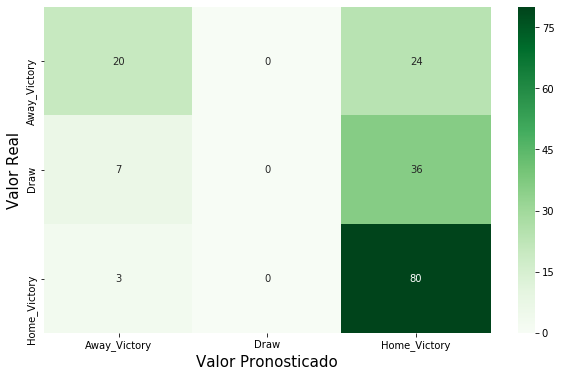

In [405]:
y_pred, clasificador = Support_Vector_Classification(X_train, y_train, X_test, y_test, 'rbf', 10.0, 0.001)
print("\nSVM" , metrics.accuracy_score(y_test, y_pred))
TP = resultados_modelo(y_test, y_pred, result, "Support Vector Machine Parametros Tuneados")
Confusion_Matrix(y_test, y_pred)

# Ahora vamos a probar aplicando PCA previamente a los modelos:

In [406]:
X = match.drop(columns = {'date','season','stage','target', 'match_api_id'})
y = match.target
X_std = StandardScaler().fit_transform(X)

<Figure size 432x288 with 0 Axes>

<BarContainer object of 26 artists>

Text(0, 0.5, 'Ratio de Varianza Explicada')

Text(0.5, 0, 'Componentes Principales')

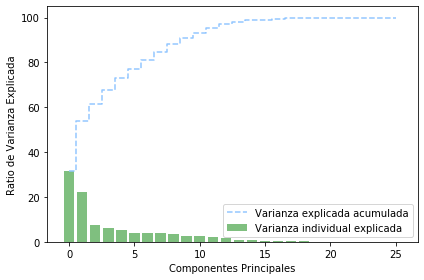

In [407]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(26), var_exp, alpha=0.5, align='center',label='Varianza individual explicada', color='g')
    plt.step(range(26), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout();

In [408]:
pca = PCA(n_components=4)
pca.fit(X_std)
X_pca = pca.transform(X_std)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
X_pca = pd.DataFrame(data = X_pca, columns = ['comp_1','comp_2','comp_3','comp_4'])#,'comp_5'])
columns = ['date','season','stage','target', 'match_api_id']
match_pca = pd.concat([match[columns], X_pca],join='inner', axis=1)
match_pca

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

original shape:    (1634, 26)
transformed shape: (1634, 4)


,date,season,stage,target,match_api_id,comp_1,comp_2,comp_3,comp_4
0,2008-08-30,2008/2009,1,1,530023,1.373209,-2.878122,7.111278,-0.876296
1,2009-11-28,2009/2010,12,0,684768,2.366251,0.907854,-0.059210,-0.241070
2,2010-10-23,2010/2011,8,-1,875616,1.739092,1.183042,0.325939,-0.397409
3,2012-03-11,2011/2012,27,0,1051907,1.922962,-0.589079,-1.545152,-0.279405
4,2010-05-08,2009/2010,37,1,685195,-0.784057,-1.623649,0.329673,0.240149
...,...,...,...,...,...,...,...,...,...
1629,2015-02-21,2014/2015,24,-1,1778265,-3.222847,-0.792017,0.738365,0.254617
1630,2016-04-02,2015/2016,31,1,2030462,-1.331152,-0.637354,0.102909,-0.835055
1631,2009-01-17,2008/2009,19,1,530449,2.563528,-2.514904,2.808482,1.772555
1632,2008-09-14,2008/2009,2,1,530094,2.612255,-2.111814,6.221840,-2.192610


#### Hacemos el split con el nuevo conjunto creado con las tres variables obtenidas:

In [409]:
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match_pca, '2015/2016', 18)

(1464, 4) (170, 4) (1464,) (170,)


### Grid Search Hyperparameters Random Forest

In [410]:
# Grid Search
parameters = {'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12], 'n_estimators': [200, 300,400, 500]}
grid = GridSearchCV(RandomForestClassifier(),parameters,refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)
grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "Random Forest Grid Search + PCA")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              mi...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                  

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 200}

Accuracy: 0.5235294117647059
              precision    recall  f1-score   support

          -1       0.45      0.43      0.44        44
           0       0.22      0.05      0.08        43
           1       0.57      0.82      0.67        83

    accuracy                           0.52       170
   macro avg       0.42      0.43      0.40       170
weighted avg       0.45      0.52      0.46       170

[[19  4 21]
 [11  2 30]
 [12  3 68]]


Una vez encontrados los mejores parámetros vemos como el modelo funciona bastante bien


Random Forrest 0.5411764705882353
Accuracy: 0.5411764705882353
              precision    recall  f1-score   support

          -1       0.50      0.43      0.46        44
           0       0.25      0.07      0.11        43
           1       0.58      0.84      0.69        83

    accuracy                           0.54       170
   macro avg       0.44      0.45      0.42       170
weighted avg       0.48      0.54      0.48       170

[[19  5 20]
 [10  3 30]
 [ 9  4 70]]


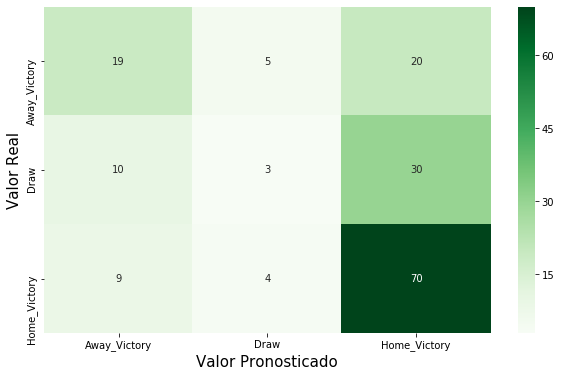

In [411]:
#Random_Forest(X_train, y_train, X_test, y_test, n_estimators, bootstrap, max_depth, max_features, min_samples_leaf,min_samples_split)
y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 90, 3, 4, 12)
print("\nRandom Forrest" , metrics.accuracy_score(y_test, y_pred))
TP = resultados_modelo(y_test, y_pred, result, "Random Forest con PCA Tuneado")
Confusion_Matrix(y_test, y_pred)

### Grid Search Hyperparameters XGBOOST

In [412]:
params = {'learning_rate' : [0.1,0.01], 'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5]    }
grid = GridSearchCV(XGBClassifier(),params,refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)
grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "XGboost Grid Search + PCA")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='warn', n_jobs=1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                    

{'colsample_bytree': 0.6,
 'gamma': 2,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 10,
 'subsample': 1.0}

Accuracy: 0.5705882352941176
              precision    recall  f1-score   support

          -1       0.68      0.43      0.53        44
           0       0.00      0.00      0.00        43
           1       0.56      0.94      0.70        83

    accuracy                           0.57       170
   macro avg       0.41      0.46      0.41       170
weighted avg       0.45      0.57      0.48       170

[[19  1 24]
 [ 6  0 37]
 [ 3  2 78]]


### Grid Search Hyperparameters ADABOOST

In [413]:
params = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}
grid = GridSearchCV(AdaBoostClassifier(), params, refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)
grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "AdaBoost Grid Search + PCA")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [500, 1000, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'learning_rate': 0.01, 'n_estimators': 1000}

Accuracy: 0.5588235294117647
              precision    recall  f1-score   support

          -1       0.50      0.45      0.48        44
           0       1.00      0.02      0.05        43
           1       0.57      0.89      0.70        83

    accuracy                           0.56       170
   macro avg       0.69      0.46      0.41       170
weighted avg       0.66      0.56      0.48       170

[[20  0 24]
 [11  1 31]
 [ 9  0 74]]


Accuracy: 0.5588235294117647
              precision    recall  f1-score   support

          -1       0.50      0.45      0.48        44
           0       1.00      0.02      0.05        43
           1       0.57      0.89      0.70        83

    accuracy                           0.56       170
   macro avg       0.69      0.46      0.41       170
weighted avg       0.66      0.56      0.48       170

[[20  0 24]
 [11  1 31]
 [ 9  0 74]]


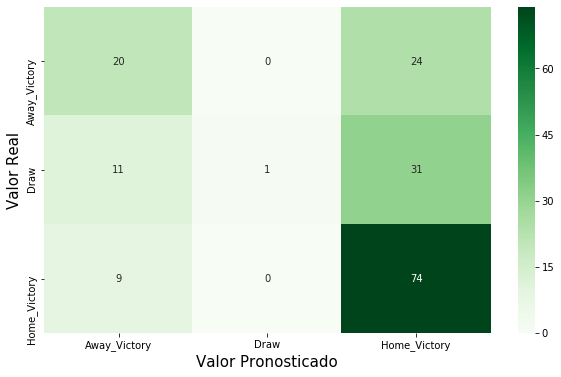

In [414]:
y_pred, clasificador = AdaBoost_Clasificator(X_train, y_train, X_test, y_test, 0.01, 1000)
#print("\nAda Boost" , metrics.accuracy_score(y_test, y_pred))
TP = resultados_modelo(y_test, y_pred, result, "Ada Boost Tuneado")
Confusion_Matrix(y_test, y_pred)

### Grid Search Hyperparameters KNeighbors

In [415]:
parameters = {'n_neighbors':[4,5,6,7], 'leaf_size':[1,3,5], 'algorithm':['auto', 'kd_tree'], 'n_jobs':[-1]}

grid = GridSearchCV(KNeighborsClassifier(), parameters, refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)
grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "K Neighbors Grid Search + PCA")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=1,
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5], 'n_jobs': [-1],
                         'n_neighbors': [4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 7}

Accuracy: 0.5588235294117647
              precision    recall  f1-score   support

          -1       0.46      0.55      0.50        44
           0       0.50      0.30      0.38        43
           1       0.63      0.70      0.66        83

    accuracy                           0.56       170
   macro avg       0.53      0.52      0.51       170
weighted avg       0.55      0.56      0.55       170

[[24  5 15]
 [11 13 19]
 [17  8 58]]


There isn't a hyper-parameter to tune, so you have nothing to grid search over.
First off GaussianNB only accepts priors as an argument so unless you have some priors to set for your model ahead of time you will have nothing to grid search over.

### Grid Search Hyperparameters Support Vector Classification

In [416]:
# Grid Search
parameters = {'C':[1.0,10.0,100],'gamma':[1,0.1,0.001], 'kernel':['linear','rbf']}
grid = GridSearchCV(SVC(),parameters,refit = True, cv = ShuffleSplit(test_size=0.20, n_splits=1),
                       verbose=0, n_jobs=1)
grid.fit(X_train,y_train)

grid.best_params_
y_pred = grid.predict(X_test)

TP = resultados_modelo(y_test, y_pred, result, "SVC Grid Search + PCA")

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [1.0, 10.0, 100], 'gamma': [1, 0.1, 0.001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

Accuracy: 0.5647058823529412
              precision    recall  f1-score   support

          -1       0.53      0.43      0.48        44
           0       0.00      0.00      0.00        43
           1       0.57      0.93      0.71        83

    accuracy                           0.56       170
   macro avg       0.37      0.45      0.39       170
weighted avg       0.42      0.56      0.47       170

[[19  0 25]
 [11  0 32]
 [ 6  0 77]]



Support Vector Classification 0.5647058823529412
Accuracy: 0.5647058823529412
              precision    recall  f1-score   support

          -1       0.53      0.43      0.48        44
           0       0.00      0.00      0.00        43
           1       0.57      0.93      0.71        83

    accuracy                           0.56       170
   macro avg       0.37      0.45      0.39       170
weighted avg       0.42      0.56      0.47       170

[[19  0 25]
 [11  0 32]
 [ 6  0 77]]


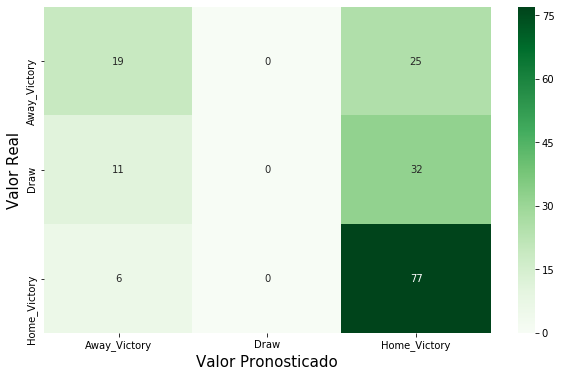

In [417]:
y_pred, clasificator = Support_Vector_Classification(X_train, y_train, X_test, y_test, 'rbf', 1.0, 0.1)
print("\nSupport Vector Classification", metrics.accuracy_score(y_test, y_pred))
TP = resultados_modelo(y_test, y_pred, result, "Support Vector Classification Tuneado + PCA")
Confusion_Matrix(y_test, y_pred)

In [418]:
result.sort_values(by = 'Accuracy', ascending = False)

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory
12,SVC Grid Search,0.588235,20,0,80
13,Support Vector Machine Parametros Tuneados,0.588235,20,0,80
16,XGboost Grid Search + PCA,0.570588,19,0,78
5,AdaBoost Classifier,0.570588,21,0,76
9,Random Forest Grid Search,0.570588,22,0,75
2,Random Forrest,0.570588,22,0,75
8,Neuronal Net,0.564706,24,0,72
21,Support Vector Classification Tuneado + PCA,0.564706,19,0,77
20,SVC Grid Search + PCA,0.564706,19,0,77
10,Random Forest Parametros Tuneados,0.564706,21,0,75


In [420]:
y_pred = Gaussian_Clasificator(X_train, y_train, X_test, y_test, 2)
print('\n Gaussian Model + PCA')
TP = resultados_modelo(y_test, y_pred, result, "Gaussian Model + PCA")
y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 80, 2, 3, 8)
print('\n Random Forrest + PCA')
TP = resultados_modelo(y_test, y_pred, result, "Random Forrest + PCA")
y_pred = Support_Vector_Classification(X_train, y_train, X_test, y_test, 'rbf', 1.0, 0.1)



 Gaussian Model + PCA
Accuracy: 0.5588235294117647
              precision    recall  f1-score   support

          -1       0.55      0.36      0.44        44
           0       0.33      0.07      0.12        43
           1       0.58      0.92      0.71        83

    accuracy                           0.56       170
   macro avg       0.49      0.45      0.42       170
weighted avg       0.51      0.56      0.49       170

[[16  4 24]
 [ 8  3 32]
 [ 5  2 76]]

 Random Forrest + PCA
Accuracy: 0.5411764705882353
              precision    recall  f1-score   support

          -1       0.51      0.43      0.47        44
           0       0.20      0.05      0.08        43
           1       0.58      0.86      0.69        83

    accuracy                           0.54       170
   macro avg       0.43      0.44      0.41       170
weighted avg       0.47      0.54      0.48       170

[[19  4 21]
 [10  2 31]
 [ 8  4 71]]


In [421]:
result['Hits'] =result['Aciertos_H.Lose'] + result['Aciertos_H.Draw'] + result['Aciertos_H.Victory']
result.sort_values(by = 'Accuracy', ascending = False).head(10)

,Algoritmo_Utilizado,Accuracy,Aciertos_H.Lose,Aciertos_H.Draw,Aciertos_H.Victory,Hits
13,Support Vector Machine Parametros Tuneados,0.588235,20,0,80,100
12,SVC Grid Search,0.588235,20,0,80,100
16,XGboost Grid Search + PCA,0.570588,19,0,78,97
2,Random Forrest,0.570588,22,0,75,97
9,Random Forest Grid Search,0.570588,22,0,75,97
5,AdaBoost Classifier,0.570588,21,0,76,97
8,Neuronal Net,0.564706,24,0,72,96
21,Support Vector Classification Tuneado + PCA,0.564706,19,0,77,96
10,Random Forest Parametros Tuneados,0.564706,21,0,75,96
20,SVC Grid Search + PCA,0.564706,19,0,77,96


### Apply Out Predictions To real Betting Cuotes

### Modelo Final Elegido para España:

In [424]:
match, country = filter_season_Country(matches, 'Spain')
X_train, X_test, y_train, y_test, test, train = train_test_split_season_stage(match, '2015/2016', 18)
X_train, X_test = normalizar_conjuntos(X_train, X_test)

(1464, 26) (170, 26) (1464,) (170,)


In [425]:
### Elegimos este modelo porque es la puntuación mas alta capaz de acertar algún empate


SVM 0.5882352941176471


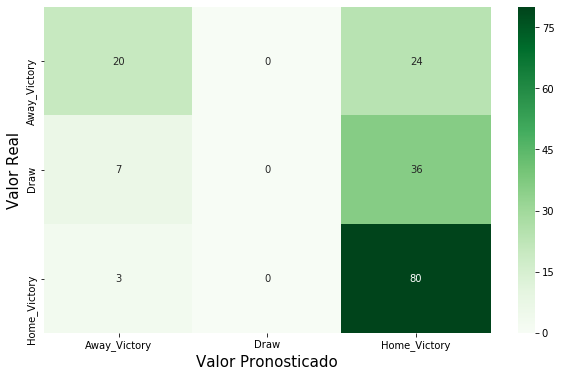

In [426]:
y_pred, clasificador = Support_Vector_Classification(X_train, y_train, X_test, y_test, 'rbf', 10.0, 0.001)
print("\nSVM" , metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [427]:
# y_pred, clasificador = Random_Forest(X_train, y_train, X_test, y_test, 200, True, 80, 2, 5, 10)
# print('\n Random Forrest', metrics.accuracy_score(y_test, y_pred))
# Confusion_Matrix(y_test, y_pred)

In [428]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…

In [429]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, clasificador, bets, columnas, casa_apuestas, matches, 100 )

William Hill 

Confiamos en todas nuestras predicciones: € 812.9999999999998
Yield %  4.78 Total Apostado:  17000

Estrategia A, probabilidad superior al 66%: € -60.000000000000014
Yield %  -1.88 Total Apostado:  3200

Estrategia B, probabilidad superior al 74%: € 145.0
Yield %  24.17 Total Apostado:  600

Estrategia C, probabilidad superior al 80%: € 0.0
Yield %  nan Total Apostado:  0


### Voting Classifier

In [430]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor

In [431]:
clf1 =  SVC(kernel = 'rbf', C = 10, gamma = 0.001, probability=True)
clf2 = RandomForestClassifier(n_estimators = 200, bootstrap = True, max_depth = 90, max_features = 2, min_samples_leaf = 5,
                                       min_samples_split = 12)
clf3 =  KNeighborsClassifier()
#clf3 = AdaBoostClassifier(learning_rate = 0.01, n_estimators = 500)
vot_hard = VotingClassifier( estimators=[('SVM', clf1), ('RF', clf2), ('KNN', clf3)], voting='hard')
vot_hard.fit(X_train,y_train)
y_pred = vot_hard.predict(X_test)

print("\nHard_Voting_Classifier",metrics.accuracy_score(y_test, y_pred) )

VotingClassifier(estimators=[('SVM',
                              SVC(C=10, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=0.001, kernel='rbf',
                                  max_iter=-1, probability=True,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('RF',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=90,
                                                     max_features=2,
                                                     max...
                                                     min_samples_split=12,
                          


Hard_Voting_Classifier 0.5764705882352941


### Weighted Average (Soft Voting)

In [434]:
soft_voting = VotingClassifier(estimators=[('SVM', clf1), ('RF', clf2), ('KNN', clf3)], voting='soft', weights=[1, 2, 0.5])
soft_voting.fit(X_train,y_train)
y_pred = soft_voting.predict(X_test)

print("\nHard_Voting_Classifier",metrics.accuracy_score(y_test, y_pred) )

VotingClassifier(estimators=[('SVM',
                              SVC(C=10, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=0.001, kernel='rbf',
                                  max_iter=-1, probability=True,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('RF',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=90,
                                                     max_features=2,
                                                     max...
                                                     min_samples_split=12,
                          


Hard_Voting_Classifier 0.5823529411764706



Soft Voting 0.5823529411764706


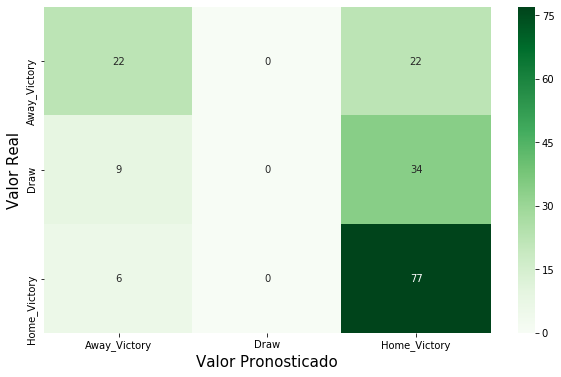

In [435]:
print("\nSoft Voting" , metrics.accuracy_score(y_test, y_pred))
Confusion_Matrix(y_test, y_pred)

In [319]:
w = widgets.SelectMultiple(description="Casa Apuestas a elegir:",options= lista)
display(w)

SelectMultiple(description='Casa Apuestas a elegir:', options=('Bet365', 'Bet&Win', 'Interwetten', 'William Hi…

In [320]:
columnas, casa_apuestas = filter_country_selected(w, bets.columns)
apply_model_to_bets(test, y_pred, soft_voting, bets, columnas, casa_apuestas, matches, 100 )

('Bet365',) 

Confiamos en todas nuestras predicciones: € 468.0
Yield %  2.92 Total Apostado:  16000

Estrategia A, probabilidad superior al 66%: € 275.0
Yield %  10.19 Total Apostado:  2700

Estrategia B, probabilidad superior al 74%: € 167.0
Yield %  16.7 Total Apostado:  1000

Estrategia B, probabilidad superior al 80%: € 57.0
Yield %  14.25 Total Apostado:  400


## PLAYERS

In [350]:
players = create_table("Player_Attributes",conexion)

In [351]:
players.describe().T

,count,mean,std,min,25%,50%,75%,max
id,183978.0,91989.500000,53110.018250,1.0,45995.25,91989.5,137983.75,183978.0
player_fifa_api_id,183978.0,165671.524291,53851.094769,2.0,155798.00,183488.0,199848.00,234141.0
player_api_id,183978.0,135900.617324,136927.840510,2625.0,34763.00,77741.0,191080.00,750584.0
overall_rating,183142.0,68.600015,7.041139,33.0,64.00,69.0,73.00,94.0
potential,183142.0,73.460353,6.592271,39.0,69.00,74.0,78.00,97.0
crossing,183142.0,55.086883,17.242135,1.0,45.00,59.0,68.00,95.0
finishing,183142.0,49.921078,19.038705,1.0,34.00,53.0,65.00,97.0
heading_accuracy,183142.0,57.266023,16.488905,1.0,49.00,60.0,68.00,98.0
short_passing,183142.0,62.429672,14.194068,3.0,57.00,65.0,72.00,97.0
volleys,181265.0,49.468436,18.256618,1.0,35.00,52.0,64.00,93.0


In [352]:
#players.isnull().sum()
print_datatype('int64',players)


Data Frame 'Matches' contains following columns of int64 data


,Unique Values,qty,na
player_api_id,"[505942, 155782, 162549, 30572, 23780, 27316, ...",11060,0
player_fifa_api_id,"[218353, 189615, 186170, 140161, 17725, 158138...",11062,0
id,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",183978,0


In [353]:
print_datatype('float',players)


Data Frame 'Matches' contains following columns of float data


,Unique Values,qty,na
potential,"[71.0, 66.0, 65.0, 76.0, 75.0, 77.0, 78.0, 79....",57,836
overall_rating,"[67.0, 62.0, 61.0, 74.0, 73.0, 71.0, 70.0, 69....",62,836
reactions,"[47.0, 46.0, 67.0, 71.0, 69.0, 70.0, 66.0, 62....",79,836
jumping,"[58.0, 85.0, 84.0, 77.0, 73.0, 64.0, 48.0, 65....",80,2713
balance,"[65.0, 90.0, 87.0, 62.0, 92.0, 84.0, 56.0, 41....",82,2713
agility,"[59.0, 78.0, 79.0, 81.0, 77.0, 74.0, 85.0, 76....",82,2713
strength,"[76.0, 56.0, 50.0, 49.0, 48.0, 43.0, 37.0, 38....",83,836
stamina,"[54.0, 79.0, 80.0, 77.0, 76.0, 74.0, 73.0, 63....",85,836
sprint_speed,"[64.0, 78.0, 82.0, 81.0, 72.0, 47.0, 46.0, 59....",86,836
acceleration,"[60.0, 79.0, 80.0, 84.0, 85.0, 69.0, 43.0, 42....",87,836


In [354]:
print_datatype('object',players)


Data Frame 'Matches' contains following columns of object data


,Unique Values,qty,na
preferred_foot,"[right, left, None]",3,836
attacking_work_rate,"[medium, high, None, low, None, le, norm, stoc...",9,3230
defensive_work_rate,"[medium, high, low, _0, None, 5, ean, o, 1, or...",20,836
date,"[2016-02-18 00:00:00, 2015-11-19 00:00:00, 201...",197,0


In [355]:
players = players.dropna()
print("Jugadores de los que tenemos todas las estadísticas: ", len(players),
      "\nCeldas restantes con valores nulos: ",players.isnull().sum().sum())

Jugadores de los que tenemos todas las estadísticas:  180354 
Celdas restantes con valores nulos:  0


In [356]:
players.iloc[:,4:]

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,83.0,85.0,right,medium,low,84.0,77.0,59.0,89.0,77.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,78.0,80.0,right,medium,low,74.0,76.0,53.0,84.0,77.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,77.0,80.0,right,medium,low,74.0,71.0,53.0,84.0,77.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,78.0,81.0,right,medium,low,74.0,64.0,57.0,86.0,77.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


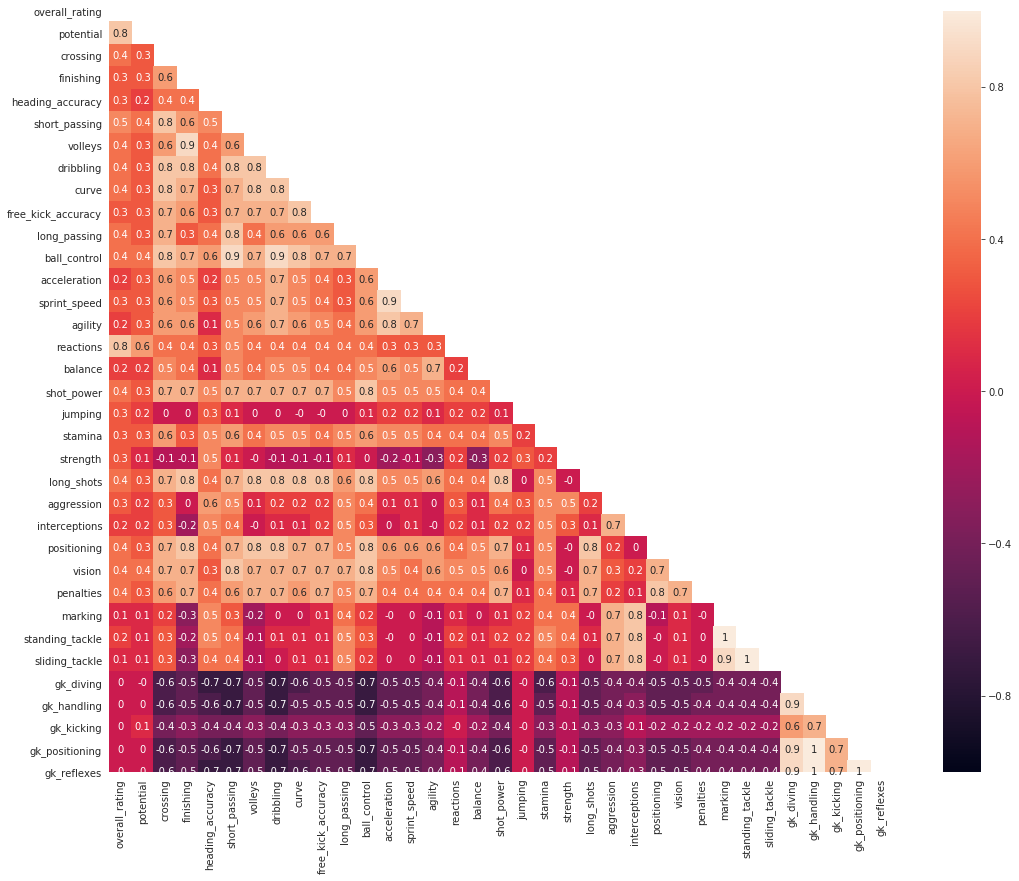

In [357]:
corr = players.iloc[:,4:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 14))
    ax = sns.heatmap(round(corr,1), mask=mask, vmax=1 ,vmin = -1, annot=True, square=True)

In [358]:
corr_1 = corr['overall_rating'].sort_values( ascending=False)
corr_1 = pd.DataFrame(corr_1)
corr_1

,overall_rating
overall_rating,1.000000
reactions,0.771856
potential,0.765435
short_passing,0.458243
ball_control,0.443991
long_passing,0.434525
vision,0.431493
shot_power,0.428053
penalties,0.392715
long_shots,0.392668


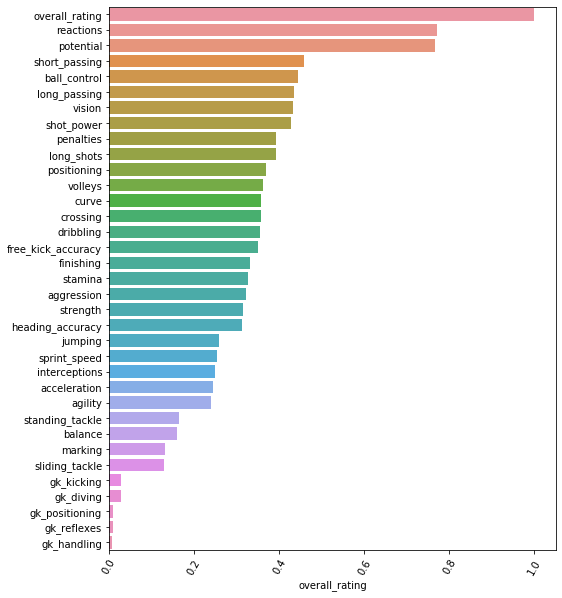

In [359]:
ax = plt.subplots(figsize=(8, 10))
ax = sns.barplot(y = corr_1.index, x = "overall_rating", data = corr_1)
plt.xticks(rotation=60);

In [360]:
playeros = pd.read_sql("SELECT * FROM Player_Attributes a \
           INNER JOIN (SELECT player_name, player_api_id AS p_id FROM Player) b ON a.player_api_id = b.p_id;", conexion)
drop_cols = ['id','player_fifa_api_id','date','preferred_foot', 'attacking_work_rate','defensive_work_rate']
playeros['date'] = pd.to_datetime(playeros['date'])
playeros = playeros[playeros.date > pd.datetime(2015,1,1)]
playeros = playeros[~playeros.overall_rating.isnull()].sort_values('date', ascending=False)
playeros = playeros.drop_duplicates(subset='player_api_id', keep='first')
playeros = playeros.drop(drop_cols, axis=1)
playeros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7675 entries, 95620 to 76744
Data columns (total 38 columns):
player_api_id         7675 non-null int64
overall_rating        7675 non-null float64
potential             7675 non-null float64
crossing              7675 non-null float64
finishing             7675 non-null float64
heading_accuracy      7675 non-null float64
short_passing         7675 non-null float64
volleys               7675 non-null float64
dribbling             7675 non-null float64
curve                 7675 non-null float64
free_kick_accuracy    7675 non-null float64
long_passing          7675 non-null float64
ball_control          7675 non-null float64
acceleration          7675 non-null float64
sprint_speed          7675 non-null float64
agility               7675 non-null float64
reactions             7675 non-null float64
balance               7675 non-null float64
shot_power            7675 non-null float64
jumping               7675 non-null float64
stamina   

In [361]:
playeros.shape

(7675, 38)

In [362]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
target = ['player_api_id', 'player_name', 'p_id']
x = playeros.drop(columns = target).values
y = playeros[target].values
X_std = StandardScaler().fit_transform(x)
X_std.shape

(7675, 35)

In [363]:
# Calculamos la matriz de covarianza

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

#Calculamos los autovalores y autovectores de la matriz y los mostramos

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

NumPy covariance matrix: 
[[ 1.00013031  0.81288868  0.28962071 ...  0.02207081  0.02486732
   0.02572533]
 [ 0.81288868  1.00013031  0.24047661 ... -0.02443394 -0.02472043
  -0.02098521]
 [ 0.28962071  0.24047661  1.00013031 ... -0.65753382 -0.66471957
  -0.66675541]
 ...
 [ 0.02207081 -0.02443394 -0.65753382 ...  1.00013031  0.95961592
   0.96064788]
 [ 0.02486732 -0.02472043 -0.66471957 ...  0.95961592  1.00013031
   0.96718541]
 [ 0.02572533 -0.02098521 -0.66675541 ...  0.96064788  0.96718541
   1.00013031]]
Eigenvectors 
[[ 0.08045043 -0.02269639  0.50531027 ...  0.0169282   0.00142758
  -0.00876755]
 [ 0.07541136 -0.04920864  0.41332602 ... -0.01264234 -0.01046383
  -0.01313674]
 [ 0.20954733 -0.02881333  0.01174984 ...  0.02174745 -0.00202379
   0.02757534]
 ...
 [-0.20269623 -0.11222019  0.21147357 ...  0.0284907   0.02397639
  -0.04076689]
 [-0.20449749 -0.11133316  0.2133265  ...  0.06010952 -0.86189326
   0.03320647]
 [-0.20473216 -0.11209874  0.21387076 ... -0.3016458   0.2

In [364]:
#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
17.165732471848948
5.802798891885423
3.0441905464456243
2.128112583186041
1.5208420832977774
0.8126811965560199
0.5672196345153968
0.38050189450326505
0.3681059121629466
0.2981834464155753
0.27876052392230255
0.2506061396865816
0.23004100621933174
0.22336384093529632
0.21403533213432402
0.18458180455577644
0.17135853276326954
0.1525119047947281
0.14373186889989006
0.1300831544781311
0.11718850141769199
0.097485491510669
0.09349744129739143
0.09074251215397795
0.08481086460737662
0.07439783585077532
0.07114123663596429
0.06526051812802665
0.04456196933673245
0.038479274626328795
0.03780403182584379
0.0351570040826762
0.03382728282960792
0.028449156211565164
0.024314965113243093


<Figure size 432x288 with 0 Axes>

<BarContainer object of 35 artists>

Text(0, 0.5, 'Ratio de Varianza Explicada')

Text(0.5, 0, 'Componentes Principales')

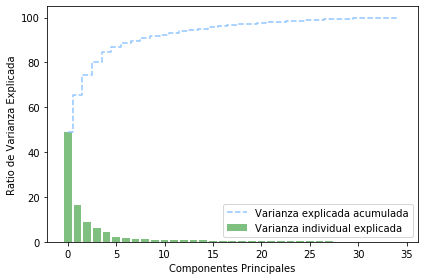

In [365]:
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(35), var_exp, alpha=0.5, align='center',label='Varianza individual explicada', color='g')
    plt.step(range(35), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout()

In [366]:
pca = PCA(n_components=3)
pca.fit(X_std)
X_pca = pca.transform(X_std)
print("original shape:   ", x.shape)
print("transformed shape:", X_pca.shape)
X_pca = pd.DataFrame(data = X_pca, columns = ['comp_1','comp_2','comp_3'])

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

original shape:    (7675, 35)
transformed shape: (7675, 3)


In [367]:
players_pca = pd.concat([playeros[target], X_pca],join='inner', axis=1)
players_pca

,player_api_id,player_name,p_id,comp_1,comp_2,comp_3
1329,495841,Adalberto Penaranda,495841,-1.831259,2.430209,0.642810
378,167027,Abdelaziz Barrada,167027,-1.382225,2.021192,0.083495
1685,281079,Adam Henley,281079,-3.462925,-3.203396,0.482374
2049,73078,Adam Pinter,73078,1.168645,-0.930121,-0.566452
6375,182843,Alessandro Iacobucci,182843,13.239190,-1.606532,-2.369218
1075,114503,Abiola Dauda,114503,-0.122602,3.213132,0.521843
1343,519835,Adam Armstrong,519835,-3.540032,0.764483,1.932668
1464,180197,Adam Collin,180197,2.564148,4.074069,-0.182905
1831,24952,Adam Le Fondre,24952,-1.723907,-3.437238,-1.170577
3831,32448,Aiden McGeady,32448,11.638140,-2.700809,0.379070


Text(0.5, 0, 'Comp 1')

Text(0.5, 0, 'Comp 2')

Text(0.5, 0, 'Comp 3')

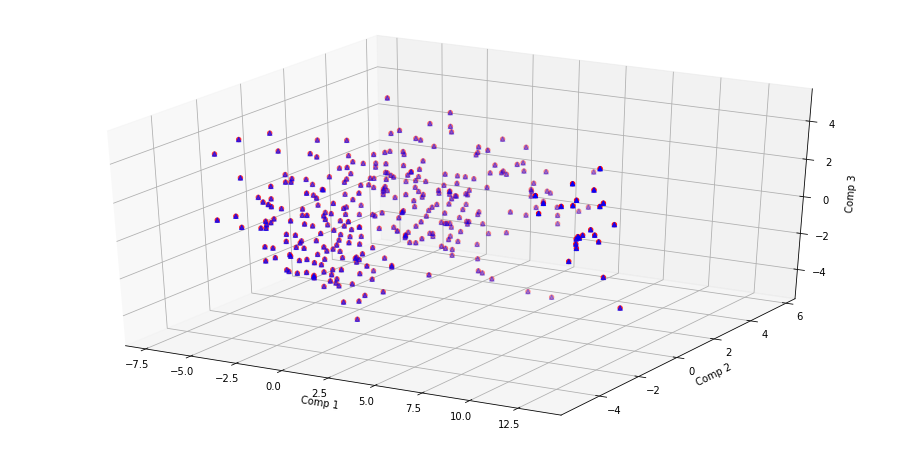

In [368]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

for c, m, zl, zh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = players_pca.comp_1
    ys = players_pca.comp_2
    zs = players_pca.comp_3
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Comp 1')
ax.set_ylabel('Comp 2')
ax.set_zlabel('Comp 3')

plt.show()

In [369]:
players = playeros.sort_values('overall_rating', ascending=False)
best_players = players[['player_api_id','player_name']].head(20)

ids = tuple(best_players.player_api_id.unique())

query = '''SELECT player_api_id, date, overall_rating, potential
           FROM Player_Attributes WHERE player_api_id in %s''' % (ids,)

evolution = pd.read_sql(query, conexion)
evolution = pd.merge(evolution, best_players)
evolution['year'] = evolution.date.str[:4].apply(int)
evolution = evolution.groupby(['year','player_api_id','player_name']).overall_rating.mean()
evolution = evolution.reset_index()

evolution.head()

,year,player_api_id,player_name,overall_rating
0,2007,19533,Neymar,73.0
1,2007,27299,Manuel Neuer,72.0
2,2007,30834,Arjen Robben,87.0
3,2007,30893,Cristiano Ronaldo,89.0
4,2007,30894,Philipp Lahm,85.5


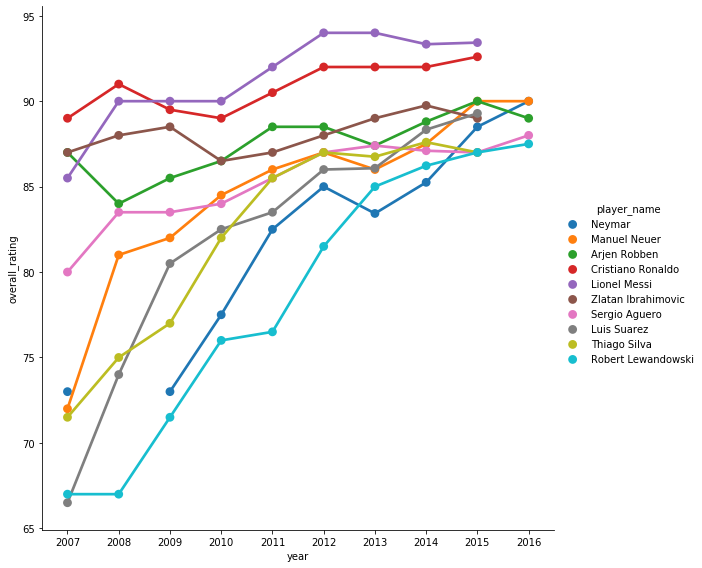

In [370]:
a = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[0:10])], x='year',
                   y='overall_rating', hue='player_name', size=8, aspect=1);


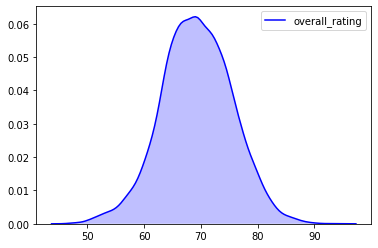

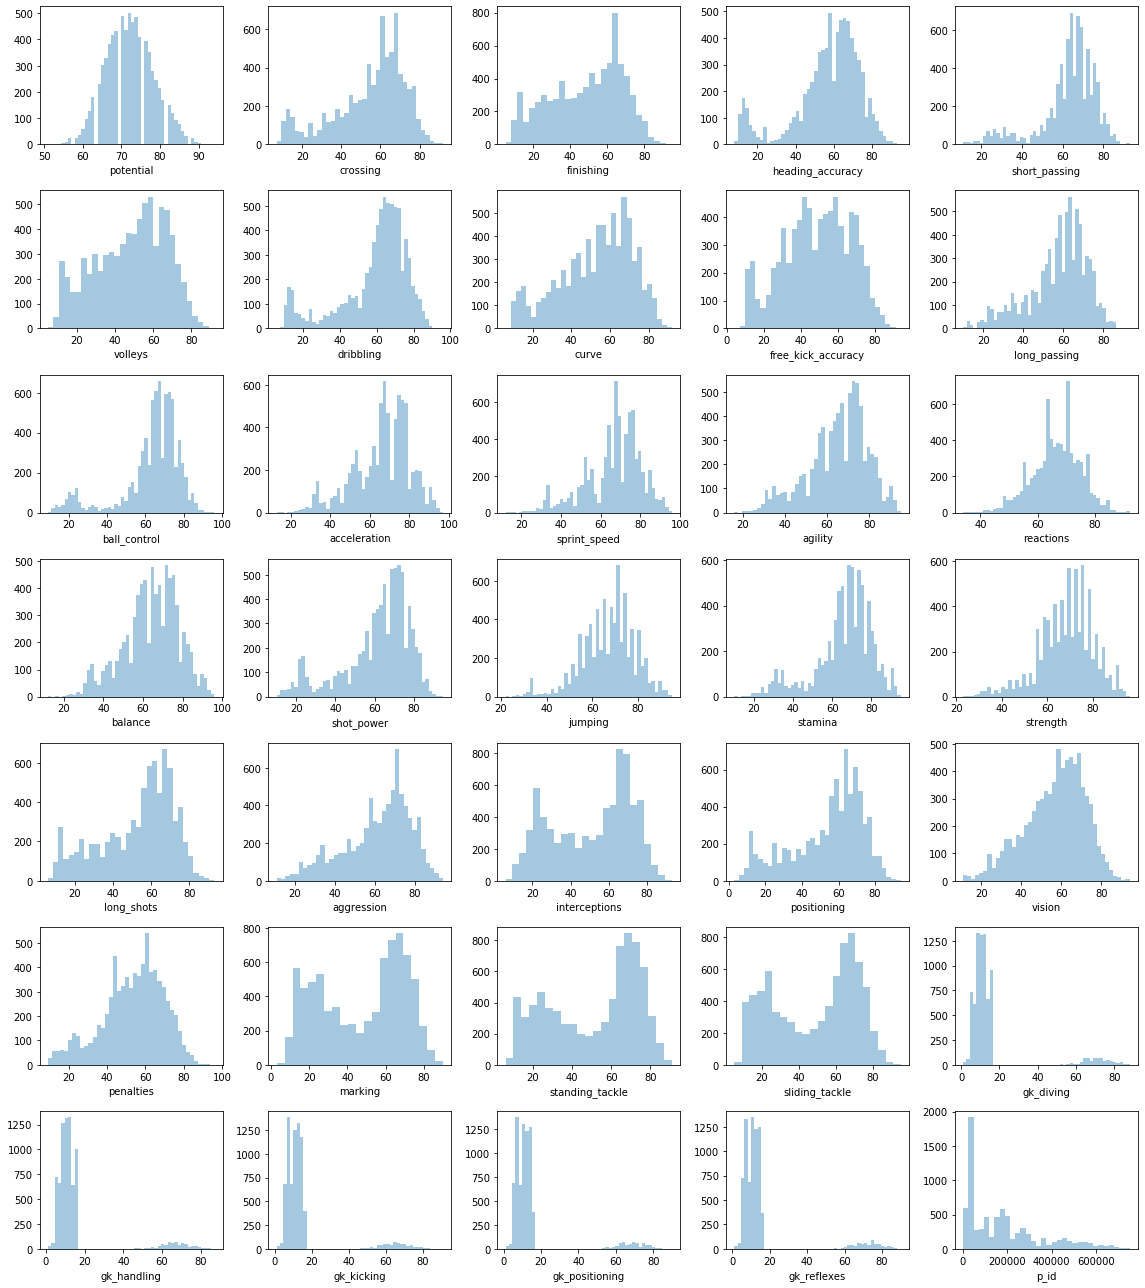

In [371]:
sns.kdeplot(players.overall_rating, shade=True, color="b")
fig1, ax1 = plt.subplots(nrows=7,ncols=5)
fig1.set_size_inches(16,18)
for i,j in enumerate(playeros.select_dtypes(include = ['float64','int64']).columns[2:].tolist()):
    sns.distplot(playeros.loc[:,j],kde = False,hist = True, ax = ax1[int(i/5)][i%5])
fig1.tight_layout();

In [372]:
idx  = "player_api_id"
cols = ['overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']

def player_comparator(player1,player2):
    
    x1 = players[players["player_name"] == player1]
    x1 = x1.groupby(["player_name"])[cols].mean()
    
    x2 = players[players["player_name"] == player2]
    x2 = x2.groupby(["player_name"])[cols].mean()
    
    z  = pd.concat([x1,x2]).transpose().reset_index()
    z  = z.rename(columns={"index":"attributes",player1:player1,player2:player2})
    z.index = z.attributes
    z[[player1,player2]].plot(kind = "barh",
                            figsize = (8,12),
                            colors = ["orange","grey"],
                            linewidth = 1 ,
                            width = .7,
                            edgecolor = ["k"]*z["attributes"].nunique()
                            )
    plt.xlabel("mean value")
    plt.legend(loc = "best",prop = {"size" : 15})
    plt.grid(True,alpha = .3)
    plt.title(player1+"  vs  "+player2)

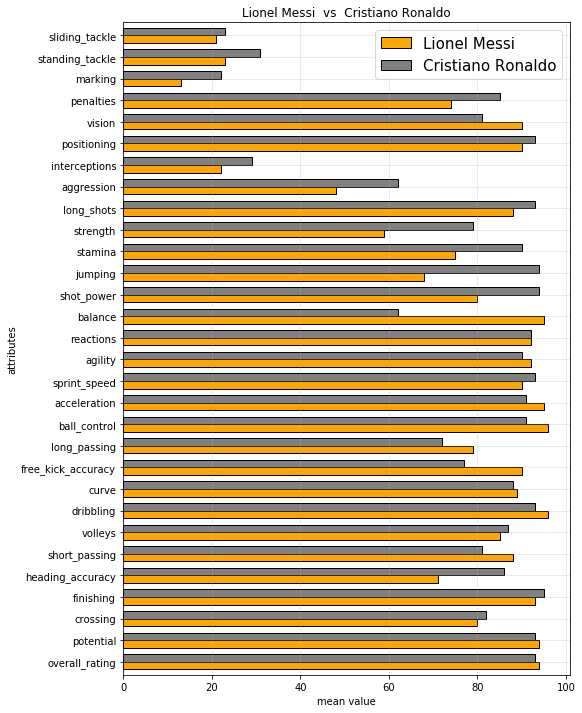

In [373]:
player_comparator('Lionel Messi','Cristiano Ronaldo')